# Техническое задание Маркетинг

## Описание 
Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

## Цель
Предсказать вероятность покупки в течение 90 дней

## Задачи
- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику roc_auc
- Выполнить тестирование

## План проведения исследования:

1. Загрузить библиотеки
2. Загрузить файлы.
3. Сделать предобработку.
4. Сделать исследовательский анализ
5. Составить из файлов таблицу с признаками.
6. Провести исследовательский анализ и предобработку.
7. Проверить признаки на мультиколлинеарность.
8. Подготовить данные для паплайна. Закодировать.
9. Паплайн с выбором модели и гиперпараметров.
10. Выбор самых важных признаков. Обучение модели на новом наборе признаков.
11. Oversampling. Обучение модели на сэмплированных данных.
12. Выбор лучшей модели. Тестирование.

## Исходные данные

Данные о покупках клиентов по дням и по товарам. В каждой записи покупка
определенного товара, его цена, количество штук.
В таблице есть списки идентификаторов, к каким категориям относится товар. Часто
это вложенные категории (например автотовары-аксессуары-освежители), но также может
включать в начале списка маркер распродажи или маркер женщинам/мужчинам.
Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка
или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому
могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594'].

датасэт apparel-purchases
история покупок
- client_id идентификатор пользователя
- quantity количество товаров в заказе
- price цена товара
- category_ids вложенные категории, к которым отнсится товар
- date дата покупки
- message_id идентификатор сообщения из рассылки

датасэт apparel-messages
история рекламных рассылок
- bulk_campaign_id идентификатор рекламной кампании
- client_id идентификатор пользователя
- message_id идентификатор сообщений
- event тип действия
- channel канал рассылки
- date дата рассылки
- created_at точное время создания сообщения

apparel-target_binary
совершит ли клиент покупку в течение следующих 90 дней
- client_id идентификатор пользователя
- target целевой признак

# Загрузка и знакомство с данными

In [9]:
import pandas as pd
import ast
from ast import literal_eval
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import PolynomialFeatures

import phik
import seaborn as sns
import numpy as np
#from category_encoders import TargetEncoder
import lightgbm as lgb
from lightgbm import LGBMClassifier
import time
from datetime import datetime, timedelta
#import optuna
from imblearn.over_sampling import SMOTE

In [10]:
start = time.time()
RANDOM_STATE = 42

In [11]:
data1 = pd.read_csv('apparel-purchases.csv')

In [12]:
data1.sample(8)

,client_id,quantity,price,category_ids,date,message_id
79697,1515915625501711918,1,699.0,"['4', '28', '57', '431']",2022-12-28,1515915625491827020-9065-63ac2e6442c3e
123898,1515915625574643585,1,1599.0,"['4', '28', '218', '652']",2023-05-25,1515915625760965792-12784-646e108044c99
124548,1515915625471255931,1,279.0,"['4', '28', '124', '415']",2023-05-27,1515915625471255931-12864-64708b7c88a64
157370,1515915625488824099,1,1049.0,"['4', '31', '326', '505']",2023-07-12,1515915625488824099-13482-64ae7253aca76
192760,1515915625568135786,1,279.0,"['4', '28', '260', '420']",2024-01-08,1515915625568135786-14421-6593b46b1dc41
6404,1515915625470926203,1,399.0,"['4', '28', '57', '431']",2022-06-02,1515915625470926203-4679-6297221701d41
157186,1515915625468108645,1,799.0,"['2', '18', '267', '1592']",2023-07-12,1515915625889079442-13482-64ae725ed1e4f
166227,1515915625499694393,1,1400.0,"['4', '28', '57', '431']",2023-08-25,1515915625499694393-13701-64e71c7750e50


In [13]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


Датафрэйм apparel purchases содержит 202 208 строк и 6 столбцов со сведениями о продажах. Столбцы целочисленного, вещественного, объектного типов. Без пропусков. 

- Столбец category_ids - это вложенные списки категорий. Предлагаю из списка категорий оставить последнюю, она более точная и последняя из всех вложенных.

- Столбец date необходимо загрузить в формате дата или перевести в этот формат.

In [15]:
data2 = pd.read_csv('apparel-messages.csv')
    

In [16]:
data2.sample(8)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
5368561,12864,1515915625964478461,1515915625964478461-12864-64708ae6aa69d,click,email,2023-05-29,2023-05-29 11:42:57
12585307,14632,1515915625488294800,1515915625488294800-14632-65c9f63ed33db,send,mobile_push,2024-02-12,2024-02-12 13:30:19
11788826,14512,1515915625592101102,1515915625592101102-14512-65ae2ef4441fa,send,mobile_push,2024-01-22,2024-01-22 09:03:29
2627815,7900,1515915625488412724,1515915625488412724-7900-6375d89a19a02,click,email,2022-11-20,2022-11-20 07:58:28
9136856,14081,1515915625575839869,1515915625575839869-14081-654d48b551ed6,send,mobile_push,2023-11-09,2023-11-09 21:01:52
3324405,8995,1515915625488541716,1515915625488541716-8995-63a5b12363f27,send,mobile_push,2022-12-23,2022-12-23 13:50:59
8186861,13898,1515915625910441963,1515915625910441963-13898-651c023da9193,send,email,2023-10-03,2023-10-03 12:32:47
1718679,6834,1515915625846678606,1515915625846678606-6834-63369b21d1b3b,send,email,2022-09-30,2022-09-30 07:32:11


In [17]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


Датафрэйм apparel-messages содержит 12 739 798 строк о рассылках для продаж и 7 столбцов. Столбцы целочисленного и объектного типов. Ничего не известно о пропусках. Датафрэйм предназначен для создания новых признаков.

In [19]:
data3 = pd.read_csv('apparel-target_binary.csv')

In [20]:
data3.sample(8)

,client_id,target
2928,1515915625470944127,0
37658,1515915625637087046,0
46549,1515915625927919728,0
21748,1515915625510187620,0
16987,1515915625491650141,0
17207,1515915625491768115,0
25069,1515915625557118510,0
43516,1515915625813763429,0


In [21]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


Датафрэйм apparel-target_binary содержит целевую переменную по 49 849 строкам и состоит из 2-х столбов.

# Предобработка данных

In [24]:
def prep(df): #создадим функцию для предобработки данных
    print(df.info())
    print ("Количество дубликатов:", df.duplicated().sum())
    print('Уникальные значения в столбцах:')
    i=0
    for i in df.columns:
        try:
            print(f"  В столбце  {i}  такие уникальные значения. Первые 20 из них:")
            print(df[i].sort_values().unique()[:20])
            
        except:
            print ('Похоже, ошибка в типе данных в столбце', i)
        print()    
    j=0
    for j in df.columns:
        print (f"Доля пропусков в столбце {j} - {round(df[j].isna().sum()*100/df.shape[0],2)} %")
      
    return df.head(20)

## apparel-purchases

In [26]:
prep(data1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB
None
Количество дубликатов: 73020
Уникальные значения в столбцах:
  В столбце  client_id  такие уникальные значения. Первые 20 из них:
[1515915625468060902 1515915625468061003 1515915625468061099
 1515915625468061100 1515915625468061170 1515915625468061514
 1515915625468061877 1515915625468061975 1515915625468061994
 1515915625468062158 1515915625468062184 1515915625468062203
 1515915625468062556 1515915625468062558 1515915625468062595
 1515915625468062659 151591562546806

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3
6,1515915625490211585,1,1699.0,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283
7,1515915625490739153,1,1999.0,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b
8,1515915625491478747,1,999.0,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59
9,1515915625491651493,1,699.0,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2


In [27]:
data1.tail(20)

,client_id,quantity,price,category_ids,date,message_id
202188,1515915626009802894,1,419.0,"['5562', '5630', '5607', '555']",2024-02-16,1515915626009802894-14633-65c9d0647754c
202189,1515915626009802894,1,419.0,"['5562', '5630', '5607', '555']",2024-02-16,1515915626009802894-14633-65c9d0647754c
202190,1515915626009802894,1,599.0,"['4', '28', '244', '432']",2024-02-16,1515915626009802894-14633-65c9d0647754c
202191,1515915626009802894,1,461.0,"['4', '28', '244', '432']",2024-02-16,1515915626009802894-14633-65c9d0647754c
202192,1515915626009802894,1,999.0,"['4', '28', '244', '432']",2024-02-16,1515915626009802894-14633-65c9d0647754c
202193,1515915626009802894,1,768.0,"['4', '28', '244', '432']",2024-02-16,1515915626009802894-14633-65c9d0647754c
202194,1515915626009802894,1,999.0,"['4', '28', '275', '421']",2024-02-16,1515915626009802894-14633-65c9d0647754c
202195,1515915626009802894,1,769.0,"['4', '28', '275', '421']",2024-02-16,1515915626009802894-14633-65c9d0647754c
202196,1515915626010221592,1,1499.0,"['4', '28', '260', '1194']",2024-02-16,1515915626010221592-14664-65cf1622434a9
202197,1515915626010221592,1,1499.0,"['4', '28', '260', '1194']",2024-02-16,1515915626010221592-14664-65cf1622434a9


Более 202 тыс. строк и 6 столбцов. Пропусков нет. Дубликаты есть. Но это может быть покупка одним клиентом одного товара в нескольких количествах. Клиенты с одним id могут быть отражены на большом количестве строк с одним и тем же товаром и с разными товарами.

### date

В столбце Дата исправим тип на соответствующий

In [31]:
data1['date'] = pd.to_datetime(data1['date'], format='%Y-%m-%d')

In [32]:
data1.sample(5)

,client_id,quantity,price,category_ids,date,message_id
24838,1515915625557224375,1,2399.0,"['4', '28', '146', '548']",2022-07-19,1515915625490747911-5335-62c7d2abb2633
177261,1515915625589850044,1,7.0,[],2023-11-10,1515915625776598995-14081-654cccb70b55a
44339,1515915625487572123,1,55.0,"['5562', '5589', '5624', '1697']",2022-11-11,1515915625487572123-7659-6368e55eec515
105971,1515915625528191792,1,35.0,"['5562', '5536', '5658', '724']",2023-04-16,1515915625566604537-11760-643674870d575
180601,1515915625584852467,1,920.0,"['4', '29', '310', '500']",2023-11-27,1515915625584852467-14192-6564697d86bb5


Данные о покупках охватывают период с 16.05.2022 по 16.02.2024.

### category_ids и category

In [35]:
data1.loc[0,'category_ids']

"['4', '28', '57', '431']"

In [36]:
len(data1.loc[0,'category_ids'])

24

Столбец category_ids - это строка из 24 символов, которую можно преобразовать в список, а можно оставить так. Каждая уникальная строка как отдельная категория.

In [38]:
data1['category_ids'].nunique()

933

933 категории.

Извлечем из этого признака дополнительный признак, преобразовав строки в списки и взяв последний уникальный номер.

In [40]:
string = "['4', '27', '176', '458']"
list_result = ast.literal_eval(string)

print(list_result)  # ['4', '27', '176', '458']
print(type(list_result))  # <class 'list'>

['4', '27', '176', '458']
<class 'list'>


In [41]:
data1['category_ids_list'] = data1['category_ids'].apply(lambda x: ast.literal_eval(x))

In [42]:
data1.head(3)

,client_id,quantity,price,category_ids,date,message_id,category_ids_list
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,"[4, 28, 57, 431]"
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,"[4, 28, 57, 431]"
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,"[4, 28, 57, 431]"


In [43]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   client_id          202208 non-null  int64         
 1   quantity           202208 non-null  int64         
 2   price              202208 non-null  float64       
 3   category_ids       202208 non-null  object        
 4   date               202208 non-null  datetime64[ns]
 5   message_id         202208 non-null  object        
 6   category_ids_list  202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 10.8+ MB


In [44]:
print(type(data1.loc[0,'category_ids_list']))

<class 'list'>


In [45]:
type(data1.loc[0,'category_ids_list'][-1])

str

In [46]:
data1['category'] = data1['category_ids_list'].apply(lambda x: x[-1] if len(x) > 0 else '0')
display(data1.head(3))
data1.info()

,client_id,quantity,price,category_ids,date,message_id,category_ids_list,category
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,"[4, 28, 57, 431]",431
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,"[4, 28, 57, 431]",431
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,"[4, 28, 57, 431]",431


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   client_id          202208 non-null  int64         
 1   quantity           202208 non-null  int64         
 2   price              202208 non-null  float64       
 3   category_ids       202208 non-null  object        
 4   date               202208 non-null  datetime64[ns]
 5   message_id         202208 non-null  object        
 6   category_ids_list  202208 non-null  object        
 7   category           200944 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 12.3+ MB


Теперь заметны пропуски в категориях. Заполним пропуски нулями.

In [48]:
print(data1['category'].sort_values().unique()[-10:])
print(data1['category'].sort_values().unique()[:10])

['987' '988' '989' '991' '992' '993' '994' '995' '999' None]
['0' '1001' '1002' '1003' '1004' '1005' '1006' '1007' '1008' '1009']


In [49]:
data1['category'] = data1['category'].fillna(0)

In [50]:
data1['category'] = data1['category'].astype(int)

In [51]:

data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   client_id          202208 non-null  int64         
 1   quantity           202208 non-null  int64         
 2   price              202208 non-null  float64       
 3   category_ids       202208 non-null  object        
 4   date               202208 non-null  datetime64[ns]
 5   message_id         202208 non-null  object        
 6   category_ids_list  202208 non-null  object        
 7   category           202208 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 12.3+ MB


In [52]:
apparel_purchases = data1.drop('category_ids_list', axis=1)
apparel_purchases.head(3)

,client_id,quantity,price,category_ids,date,message_id,category
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,431
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,431
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,431


*Итак, получили новый столбец category, состоящий из последнего целого числа вложенного списка категорий. Пустые категории заполнены нулями.*

*Также столбец Дата принял соответствующий тип.*

## apparel-messages

In [55]:
prep(data2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB
None
Количество дубликатов: 48610
Уникальные значения в столбцах:
  В столбце  bulk_campaign_id  такие уникальные значения. Первые 20 из них:
[548 563 585 594 602 634 657 676 693 721 722 742 754 766 783 817 833 849
 856 868]

  В столбце  client_id  такие уникальные значения. Первые 20 из них:
[1515915625468060902 1515915625468061003 1515915625468061099
 1515915625468061100 1515915625468061170 1515915625468061514
 1515915625468061877 1515915625468061899 1515915625468061975
 1515915625468061994 1515915625468062158 1515915625468062184
 1515915625468062203 1515

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06


Более 12 млн. строк, 7 столбцов. 48 тыс. строк дубликаты.Пропусков нет.

In [57]:
apparel_messages = data2.drop_duplicates().reset_index(drop=True)
apparel_messages

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
...,...,...,...,...,...,...,...
12691183,14657,1515915625477497874,1515915625477497874-14657-65cdd371cc86c,open,email,2024-02-15,2024-02-15 23:51:40
12691184,14657,1515915625765994334,1515915625765994334-14657-65cdd36018eac,open,email,2024-02-15,2024-02-15 23:52:20
12691185,14641,1515915625545014677,1515915625545014677-14641-65cb2434b25a1,open,email,2024-02-15,2024-02-15 23:52:40
12691186,14624,1515915625477497874,1515915625477497874-14624-65c5e22fb401e,open,email,2024-02-15,2024-02-15 23:58:40


Пропусков нет. Удалены дубликаты. Осталось 12 691 188 строк рекламных рассылок.

### date

Исправим тип столбцов с датами.

In [61]:
apparel_messages['date'] = pd.to_datetime(apparel_messages['date'], format='%Y-%m-%d')


In [62]:
apparel_messages['created_at'] = pd.to_datetime(apparel_messages['created_at'], format='%Y-%m-%d %H:%M:%S')


apparel_messages.head(5)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [63]:
apparel_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12691188 entries, 0 to 12691187
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 677.8+ MB


In [64]:
apparel_messages['date'].describe()

count                         12691188
mean     2023-06-04 17:27:00.569989632
min                2022-05-19 00:00:00
25%                2022-12-16 00:00:00
50%                2023-07-20 00:00:00
75%                2023-11-21 00:00:00
max                2024-02-15 00:00:00
Name: date, dtype: object

Исправлены типы столбца Дата и Точного времени создания сообщения. Период рекламных рассылок охватывает с 19 мая 2022 г. по 15 февраля 2024 г. Меньше, чем покупок.

### Соединим event и channel в один столбец

In [67]:
apparel_messages['event_channel'] = apparel_messages['event'] + '_' + apparel_messages['channel']
apparel_messages['event_channel']

0            open_email
1            open_email
2            open_email
3           click_email
4            open_email
               ...     
12691183     open_email
12691184     open_email
12691185     open_email
12691186     open_email
12691187     open_email
Name: event_channel, Length: 12691188, dtype: object

Получили дополнительный категориальный признак.

In [69]:
apparel_messages.head(20)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,event_channel
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20,open_email
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34,open_email
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49,open_email
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20,click_email
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52,open_email
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11,open_email
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54,open_email
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43,open_email
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16,click_email
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06,open_email


*Итак, столбцы с временем преобразованы в тип datetime64. Удалены дубликаты. Создан новый столбец содержащий соединением event и channel.*

## target

In [72]:
prep(data3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB
None
Количество дубликатов: 0
Уникальные значения в столбцах:
  В столбце  client_id  такие уникальные значения. Первые 20 из них:
[1515915625468060902 1515915625468061003 1515915625468061099
 1515915625468061100 1515915625468061170 1515915625468061514
 1515915625468061877 1515915625468061975 1515915625468061994
 1515915625468062158 1515915625468062184 1515915625468062203
 1515915625468062556 1515915625468062558 1515915625468062595
 1515915625468062659 1515915625468062723 1515915625468062757
 1515915625468062941 1515915625468063026]

  В столбце  target  такие уникальные значения. Первые 20 из них:
[0 1]

Доля пропусков в столбце client_id - 0.0 %
Доля пропусков в столбце target - 0.0 %


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0
5,1515915625468061514,0
6,1515915625468061877,0
7,1515915625468061975,0
8,1515915625468061994,0
9,1515915625468062158,0


49849 строк, 2 столбца. Пропусков нет, дубликатов нет.

*Итак, пропусков нет. Дубликатов нет. Хотя при отражении некоторых строк положительное значение целевой переменной не встречается, оно все-таки есть. Типы столбцов целочисленные.*

*Количество клиентов в файле apparel-purchases совпадает с количеством клиентов в targete.*

# Исследовательский анализ

Создадим функции для столбцов с непрерывными данными и категориальных.

In [76]:
def categ (df, column, quantity, name): #функция для анализа категориальных столбцов
    plt.figure(figsize=(22, 18))
    v1 = df[column].value_counts().head(quantity)
    print(v1)

    lb1 = v1.index
    
    fig, ax = plt.subplots(figsize=(10, 5));

    ax.pie(v1, labels=lb1, autopct='%1.1f%%');
    ax.set_title(name);

    return

In [77]:
def numbers(df, column, x_title,y_title): #функция для анализа числовых столбцов
    plt.figure(figsize=(14, 10))

    plt.subplot(2,2,1)
    df[column].hist(bins=25, range=(0,25))
    plt.ylabel(y_title)
    plt.xlabel(x_title)
    plt.title('Распределение')
        
    try:
        plt.subplot(2,2,3)
        df.boxplot(column, color = 'green')
        plt.ylabel(x_title)
        plt.title('Ящик с усами')

    except:
        print('Ящик с усами не построить')
    plt.show()
    
    print('Статистика')
    print(df[column].describe())

    return;

## apparel-purchases

In [79]:
apparel_purchases.columns

Index(['client_id', 'quantity', 'price', 'category_ids', 'date', 'message_id',
       'category'],
      dtype='object')

### client_id

In [81]:
apparel_purchases['client_id'].value_counts()

client_id
1515915625853312319    346
1515915625624308268    218
1515915625607113301    210
1515915625500232103    131
1515915625470860261    131
                      ... 
1515915625559962326      1
1515915625559941251      1
1515915625468133517      1
1515915625559866916      1
1515915626010443624      1
Name: count, Length: 49849, dtype: int64

Количество уникальных клиентов - 49849. Столько же, сколько таргетов. Часть покупок клиентов занимают более 100 строк, т.е. совершили покупки многого числа товаров, другая часть - по одному товару.

Изучим самого крупного клиента, занимающего 346 строк.

In [83]:
apparel_purchases_2319 = apparel_purchases.query('client_id == 1515915625853312319')
apparel_purchases_2319.tail(20)

,client_id,quantity,price,category_ids,date,message_id,category
180531,1515915625853312319,1,99.0,"['6060', '6058', '6065', '5501']",2023-11-26,1515915625478867789-14182-6560562d0dd8a,5501
180532,1515915625853312319,1,100.0,"['6060', '6058', '6065', '5501']",2023-11-26,1515915625478867789-14182-6560562d0dd8a,5501
180533,1515915625853312319,1,99.0,"['6060', '6058', '6065', '5501']",2023-11-26,1515915625478867789-14182-6560562d0dd8a,5501
180534,1515915625853312319,1,99.0,"['6060', '6058', '6065', '5501']",2023-11-26,1515915625478867789-14182-6560562d0dd8a,5501
180535,1515915625853312319,1,99.0,"['6060', '6058', '6065', '5501']",2023-11-26,1515915625478867789-14182-6560562d0dd8a,5501
180613,1515915625853312319,3,149.0,"['6060', '6058', '6065', '5501']",2023-11-27,1515915625478867789-14182-6560562d0dd8a,5501
180614,1515915625853312319,3,149.0,"['6060', '6058', '6065', '5501']",2023-11-27,1515915625478867789-14182-6560562d0dd8a,5501
180615,1515915625853312319,3,149.0,"['6060', '6058', '6065', '5501']",2023-11-27,1515915625478867789-14182-6560562d0dd8a,5501
180616,1515915625853312319,1,200.0,"['6060', '6058', '6067', '5498']",2023-11-27,1515915625478867789-14182-6560562d0dd8a,5498
180617,1515915625853312319,1,199.0,"['6060', '6058', '6067', '5498']",2023-11-27,1515915625478867789-14182-6560562d0dd8a,5498


Этот клиент покупает разные товары. Каждому товару и каждой единице товара посвящена отдельная строка. Клиент приобретает товары в разные даты. Каждой дате соответствуют разные id рассылок.

In [85]:
apparel_purchases_2319['category'].value_counts().head

<bound method NDFrame.head of category
510     56
464     36
5501    34
546     32
1195    29
5498    27
722     18
661     16
515     15
417     11
656     10
436      9
509      8
429      8
505      6
441      5
525      4
0        4
660      3
1595     3
5956     2
6296     2
452      2
544      2
657      2
443      1
1562     1
Name: count, dtype: int64>

Самый крупный клиент купил много товаров из разных категорий.

In [87]:
apparel_purchases_2319['message_id'].value_counts()

message_id
1515915625478867789-8902-63a2cef1c2e38     64
1515915625478867789-8504-6392e43fb150f     41
1515915625478867789-14182-6560562d0dd8a    38
1515915625478867789-9110-63ae8d09609c1     33
1515915625478867789-13392-649554cd51eb5    31
1515915625478867789-13478-64ae724c0d074    26
1515915625478867789-14052-6544b212123ae    14
1515915625478867789-13982-653237260eb41    13
1515915625478867789-8033-637dbe1c21bfa     12
1515915625478867789-13898-651c0213477f4    11
1515915625478867789-9383-63c647b36b16d      7
1515915625478867789-14161-655db23c79970     6
1515915625478867789-13952-6528e33954c5b     6
1515915625478867789-7816-6371eb1345b8f      6
1515915625478867789-13917-651fc55f3ad31     6
1515915625478867789-7845-6373358eaf65f      5
1515915625478867789-14013-653b7ad753e08     4
1515915625478867789-8364-638dac6694541      4
1515915625478867789-7180-634d2f7a3f0bd      3
1515915625478867789-9264-63be69774c528      3
1515915625478867789-8218-63848a5d2479b      3
1515915625478867789-138

In [88]:
apparel_purchases_2319['date'].value_counts()

date
2022-12-22    28
2023-07-22    28
2022-12-17    28
2023-07-12    26
2022-12-28    26
2023-01-04    21
2023-11-26    15
2023-11-08    13
2022-12-14    12
2023-10-05    11
2023-01-02    11
2023-11-27    11
2023-11-25    10
2022-12-29    10
2023-01-22     7
2023-10-20     7
2022-11-27     6
2022-11-26     6
2023-10-22     6
2022-11-18     6
2023-11-23     6
2023-10-09     6
2023-10-19     6
2022-11-15     5
2022-12-07     4
2023-10-29     4
2023-01-14     3
2022-11-28     3
2023-08-03     3
2023-12-01     2
2023-11-15     2
2023-11-12     2
2023-12-05     2
2023-09-24     2
2022-10-23     2
2023-11-06     1
2023-09-03     1
2023-01-24     1
2023-01-07     1
2022-12-10     1
2022-10-20     1
Name: count, dtype: int64

*Количество уникальных клиентов - 49849. Столько же, сколько таргетов. Часть покупок клиентов занимают более 100 строк, т.е. совершили покупки многого числа товаров, другая часть - по одному товару.*

*Дат больше, чем рассылок, по одной рассылке могут быть куплены товары в разные даты.*


### quantity

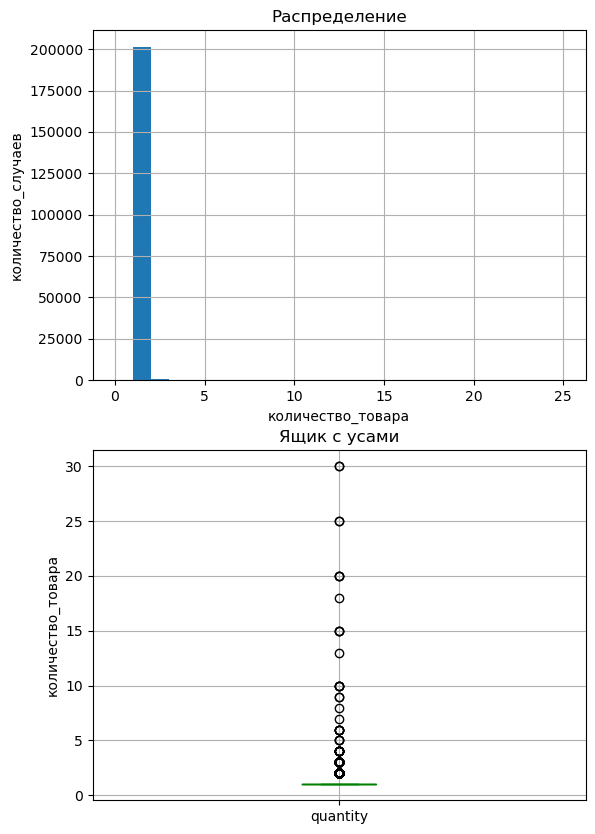

Статистика
count    202208.000000
mean          1.006483
std           0.184384
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          30.000000
Name: quantity, dtype: float64


In [91]:
numbers(apparel_purchases, 'quantity', 'количество_товара','количество_случаев')

*Каждая строка в основном содержит 1 товар (более 200 тыс. случаев). Но есть выбросы: случаи по 2-30 товаров.*

Можно ввести новый признак - количество купленных товаров.

### price

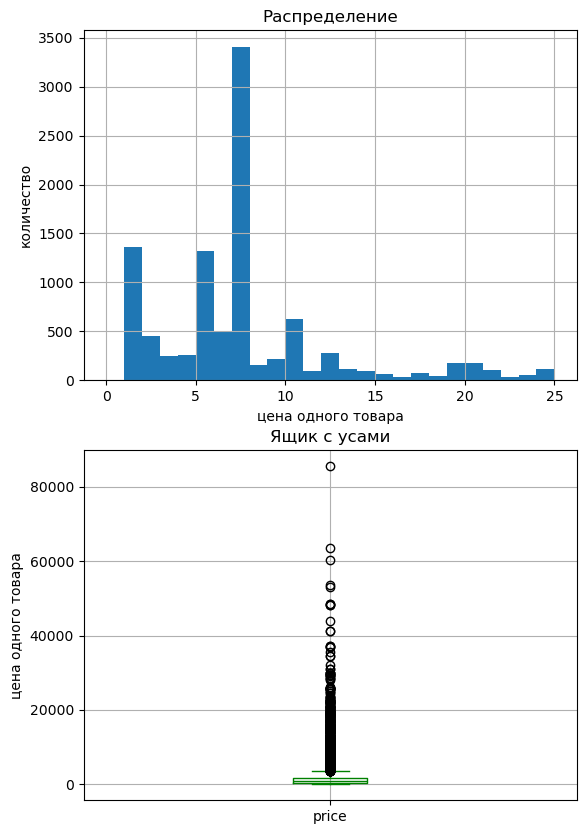

Статистика
count    202208.000000
mean       1193.301516
std        1342.252664
min           1.000000
25%         352.000000
50%         987.000000
75%        1699.000000
max       85499.000000
Name: price, dtype: float64


In [95]:
numbers(apparel_purchases, 'price', 'цена одного товара','количество')

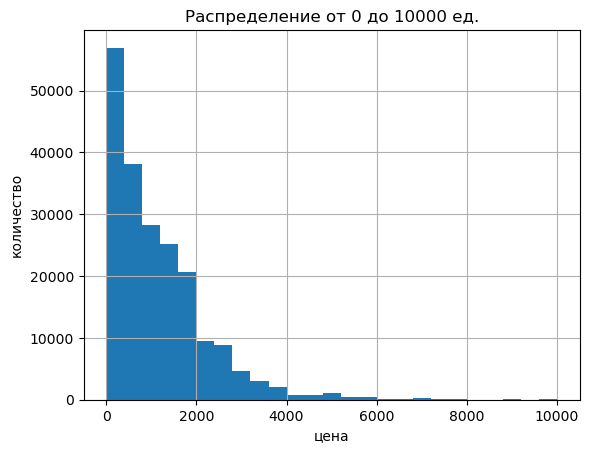

In [96]:
apparel_purchases['price'].hist(bins=25, range=(0,10000))
plt.ylabel('количество')
plt.xlabel('цена')
plt.title('Распределение от 0 до 10000 ед.');

*Цены колеблются от 1 до 10000, но чаще это 1-200. Есть выбросы.*

При агрегации можно взять сумму всех покупок по клиенту.

### category_ids

category_ids
['4', '28', '57', '431']     8626
['4', '28', '260', '420']    6989
['4', '28', '244', '432']    6821
[]                           5579
['4', '28', '275', '421']    4936
['2', '18', '258', '441']    4905
['4', '28', '62', '657']     4708
['4', '28', '62', '656']     3967
['4', '28', '124', '415']    3791
['4', '28', '275', '673']    3276
['4', '28', '213', '436']    3245
['4', '28', '343', '425']    3083
['4', '28', '290', '422']    2987
['4', '31', '326', '505']    2843
['2', '18', '344', '445']    2314
['4', '28', '249', '616']    2242
['2', '18', '61', '661']     2133
['4', '28', '146', '548']    2078
['4', '28', '58', '434']     2046
['4', '31', '324', '466']    1904
Name: count, dtype: int64


<Figure size 2200x1800 with 0 Axes>

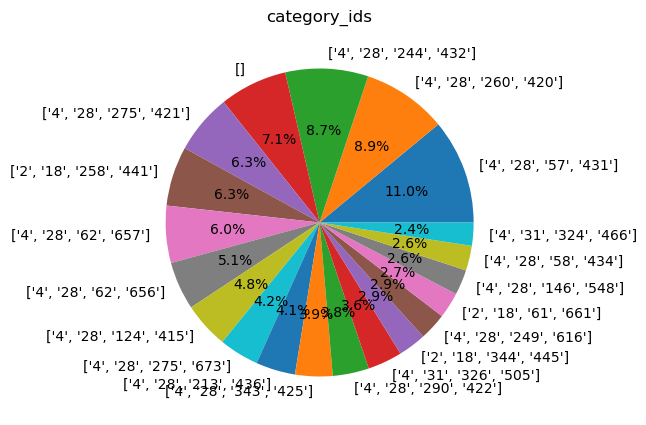

In [100]:
categ (apparel_purchases, 'category_ids', 20, 'category_ids')

In [101]:
apparel_purchases['category_ids'].value_counts()

category_ids
['4', '28', '57', '431']            8626
['4', '28', '260', '420']           6989
['4', '28', '244', '432']           6821
[]                                  5579
['4', '28', '275', '421']           4936
                                    ... 
['4', '5837', '5836', '839']           1
['5562', '5632', '5552', '1089']       1
['4', '27', '278', '471']              1
['5562', '5697', '5651', '1153']       1
['5562', '5597', '5696', '5529']       1
Name: count, Length: 933, dtype: int64

*Категории - это строки. 933 уникальных категории. Одна категория состоит просто из квадратных скобок.*

### category

In [104]:
apparel_purchases['category'].value_counts()

category
431     8626
420     6989
0       6843
432     6821
421     4936
        ... 
1727       1
1429       1
5950       1
1775       1
1579       1
Name: count, Length: 843, dtype: int64

*843 уникальных категории, полученных после преобразования строкового столбца.*

При агрегации можно взять наиболее часто встречающуюся категорию по клиенту, наиболее дорогую, последнюю категорию покупки и получить дополнительные признаки.    

### date

In [107]:
apparel_purchases['date'].describe()

count                           202208
mean     2023-03-17 02:49:35.739832064
min                2022-05-16 00:00:00
25%                2022-11-12 00:00:00
50%                2023-04-12 00:00:00
75%                2023-07-03 00:00:00
max                2024-02-16 00:00:00
Name: date, dtype: object

*Клиентская база охватывает период с 16.05.2022 по 16.02.2024.*

Из этого признака при агрегации предлагаю взять количество дней активности и получить дополнительный признаки.

### message_id

In [111]:
apparel_purchases['message_id'].value_counts()

message_id
1515915625489095763-6251-6311b13a4cf78     365
1515915625624308268-7803-636dfea7ca890     218
1515915625880116527-8725-639b2f0ad5e2e     160
1515915625607113301-13818-650a8af70fd67    148
1515915625558691508-14212-6567128370bdd    143
                                          ... 
1515915625487887289-5707-62e38257ccade       1
1515915625597731503-5707-62e38247a88c0       1
1515915625594604191-5707-62e382458eb5f       1
1515915625594340883-5739-62e3d2d9c35c2       1
1515915625495329923-5707-62e382401e741       1
Name: count, Length: 50204, dtype: int64

На 49849 клиентов было 50204 рассылки.

In [113]:
apparel_purchases['client_id'].value_counts()

client_id
1515915625853312319    346
1515915625624308268    218
1515915625607113301    210
1515915625500232103    131
1515915625470860261    131
                      ... 
1515915625559962326      1
1515915625559941251      1
1515915625468133517      1
1515915625559866916      1
1515915626010443624      1
Name: count, Length: 49849, dtype: int64

In [114]:
apparel_purchases.groupby('client_id')['message_id'].count()

client_id
1515915625468060902     7
1515915625468061003     7
1515915625468061099     1
1515915625468061100     2
1515915625468061170    19
                       ..
1515915626010261344     6
1515915626010266132     2
1515915626010439406     2
1515915626010443527     1
1515915626010443624     1
Name: message_id, Length: 49849, dtype: int64

*На каждого клиента могло быть более 1 рассылки.*

Для агрегации можно взять количество рассылок.

## apparel_messages

In [117]:
apparel_messages.columns

Index(['bulk_campaign_id', 'client_id', 'message_id', 'event', 'channel',
       'date', 'created_at', 'event_channel'],
      dtype='object')

### bulk_campaign_id

In [119]:
apparel_messages['bulk_campaign_id'].value_counts()

bulk_campaign_id
14272    104060
14276     63362
4679      50621
11760     45745
14081     44067
          ...  
657           1
1391          1
1080          1
548           1
4478          1
Name: count, Length: 2709, dtype: int64

*2709 идентификаторов рассылки.*

### client_id

In [122]:
apparel_messages['client_id'].value_counts()

client_id
1515915625516327994    3088
1515915625625548006    3067
1515915625804998560    2721
1515915625489071904    1845
1515915625489095763    1427
                       ... 
1515915625558767774       1
1515915625577289455       1
1515915625840706531       1
1515915625977549113       1
1515915625500865072       1
Name: count, Length: 53329, dtype: int64

53329 уникальных клиента. Больше, чем в файле apparel_purchases.

Рассмотрим таблицу на примере одного клиента, самого часто встречаемого.

In [124]:
apparel_messages_7994 = apparel_messages.query('client_id == 1515915625516327994')
apparel_messages_7994.tail(20)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,event_channel
12549739,14639,1515915625516327994,1515915625516327994-14639-65cb17040df9d,send,mobile_push,2024-02-13,2024-02-13 07:15:21,send_mobile_push
12551187,14635,1515915625516327994,1515915625516327994-14635-65cb219902adc,send,mobile_push,2024-02-13,2024-02-13 08:00:26,send_mobile_push
12554857,14636,1515915625516327994,1515915625516327994-14636-65cb252073619,send,mobile_push,2024-02-13,2024-02-13 08:15:30,send_mobile_push
12555592,14641,1515915625516327994,1515915625516327994-14641-65cb23d94d5ec,send,email,2024-02-13,2024-02-13 08:17:51,send_email
12572652,14637,1515915625516327994,1515915625516327994-14637-65cb21dcc7735,send,mobile_push,2024-02-13,2024-02-13 09:11:53,send_mobile_push
12586220,14634,1515915625516327994,1515915625516327994-14634-65cb2fe32b470,send,mobile_push,2024-02-13,2024-02-13 10:01:07,send_mobile_push
12608527,14643,1515915625516327994,1515915625516327994-14643-65cb921cae6db,send,mobile_push,2024-02-13,2024-02-13 16:00:30,send_mobile_push
12608620,14644,1515915625516327994,1515915625516327994-14644-65cb959193109,send,mobile_push,2024-02-13,2024-02-13 16:15:14,send_mobile_push
12611915,14646,1515915625516327994,1515915625516327994-14646-65cc731fddb6e,send,mobile_push,2024-02-14,2024-02-14 08:00:35,send_mobile_push
12613424,14647,1515915625516327994,1515915625516327994-14647-65cc769348ba3,send,mobile_push,2024-02-14,2024-02-14 08:15:20,send_mobile_push


*У каждого клиента разные рассылки, разные даты, разные каналы рассылок, в разное время одно и то же действие с рассылкой.*

*53329 уникальных клиента. Больше, чем в файле apparel_purchases.*


### message_id

In [127]:
apparel_messages['message_id'].value_counts()

message_id
1515915625489095763-6251-6311b13a4cf78     1427
1515915625490540122-6973-633edf707840d      438
1515915625490241385-6973-633edf70723d8      438
1515915625629509124-6374-63241bd1541d5      286
1515915625488270582-3433-6232d6007e929      249
                                           ... 
1515915625489968543-12052-64426bfcee0e6       1
1515915625500268486-12052-64426bfce782f       1
1515915625487017808-12052-64426bfce74d5       1
1515915625488469540-12052-64426bfce6d10       1
1515915625491736359-14656-65ce97f92a3fd       1
Name: count, Length: 9061667, dtype: int64

*Более 9 млн. разных рассылок.*

При агрегации по клиенту стоит взять посследнюю рассылку по каждому клиенту и количество строк с рассылками.

### event

event
send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: count, dtype: int64


<Figure size 2200x1800 with 0 Axes>

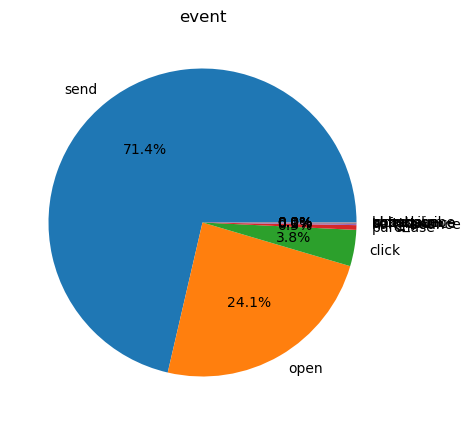

In [130]:
categ (apparel_messages, 'event', 30, 'event')

In [131]:
apparel_messages.groupby('message_id')['event'].count().sort_values()

message_id
1515915625468060902-10022-63e5ededd911f       1
1515915625556407462-14012-653a494e2d26c       1
1515915625556407462-14011-653a48f063ae6       1
1515915625556407462-14008-653a0fc031381       1
1515915625556407462-13997-65377ad4d43bd       1
                                           ... 
1515915625488270582-3433-6232d6007e929      249
1515915625629509124-6374-63241bd1541d5      286
1515915625490540122-6973-633edf707840d      438
1515915625490241385-6973-633edf70723d8      438
1515915625489095763-6251-6311b13a4cf78     1427
Name: event, Length: 9061667, dtype: int64

*Если сгруппировать со рассылкам, то на каждую рассылку может приходиться от 1 до 1427 событий.*

### channel

In [134]:
apparel_messages.groupby('message_id')['channel'].count().sort_values()

message_id
1515915625468060902-10022-63e5ededd911f       1
1515915625556407462-14012-653a494e2d26c       1
1515915625556407462-14011-653a48f063ae6       1
1515915625556407462-14008-653a0fc031381       1
1515915625556407462-13997-65377ad4d43bd       1
                                           ... 
1515915625488270582-3433-6232d6007e929      249
1515915625629509124-6374-63241bd1541d5      286
1515915625490540122-6973-633edf707840d      438
1515915625490241385-6973-633edf70723d8      438
1515915625489095763-6251-6311b13a4cf78     1427
Name: channel, Length: 9061667, dtype: int64

channel
mobile_push    7470472
email          5220716
Name: count, dtype: int64


<Figure size 2200x1800 with 0 Axes>

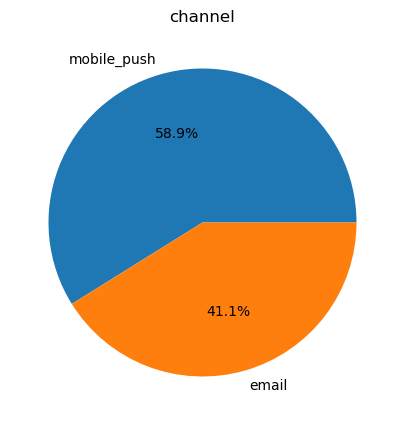

In [135]:
categ (apparel_messages, 'channel', 30, 'channel')

*На каждую рассылку приходится от 1 до 1427 каналов. Сколько событий, столько и каналов. Большинство рарассылок совершалось mobile_push.*

### event_channel

In [138]:
apparel_messages.groupby('client_id')['event_channel'].count().sort_values()

client_id
1515915625579238902       1
1515915625500403396       1
1515915625840706531       1
1515915625500865072       1
1515915625500230488       1
                       ... 
1515915625489095763    1427
1515915625489071904    1845
1515915625804998560    2721
1515915625625548006    3067
1515915625516327994    3088
Name: event_channel, Length: 53329, dtype: int64

event_channel
send_mobile_push           5120953
send_email                 3937221
open_mobile_push           2179343
open_email                  873138
click_email                 351949
click_mobile_push           131377
purchase_email               44215
hard_bounce_mobile_push      19404
purchase_mobile_push         18378
soft_bounce_email             9566
unsubscribe_email             2833
soft_bounce_mobile_push       1016
hbq_spam_email                 823
complain_email                 527
hard_bounce_email              359
subscribe_email                 85
close_mobile_push                1
Name: count, dtype: int64


<Figure size 2200x1800 with 0 Axes>

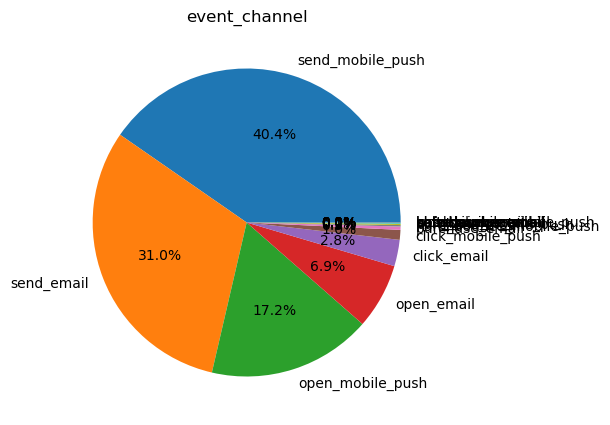

In [139]:
categ (apparel_messages, 'event_channel', 30, 'event_channel')

*На каждого клиента приходится от 1 до 3088 событий по какому-либо каналу.*

При агрегации возьмем количество событий на каждого клиента.

Соответственно большая часть рассылок отпралена по мобильным каналам.

### date

In [142]:
apparel_messages['date'].describe()

count                         12691188
mean     2023-06-04 17:27:00.569989632
min                2022-05-19 00:00:00
25%                2022-12-16 00:00:00
50%                2023-07-20 00:00:00
75%                2023-11-21 00:00:00
max                2024-02-15 00:00:00
Name: date, dtype: object

In [143]:
apparel_messages.groupby('client_id')['date'].count().sort_values()

client_id
1515915625579238902       1
1515915625500403396       1
1515915625840706531       1
1515915625500865072       1
1515915625500230488       1
                       ... 
1515915625489095763    1427
1515915625489071904    1845
1515915625804998560    2721
1515915625625548006    3067
1515915625516327994    3088
Name: date, Length: 53329, dtype: int64

In [144]:
apparel_messages['date'].value_counts()

date
2023-06-10    89173
2024-01-26    84242
2023-12-11    82568
2023-12-10    81352
2023-12-26    80116
              ...  
2023-01-08      278
2023-04-11      273
2023-01-07      259
2023-05-09      250
2023-07-02      104
Name: count, Length: 638, dtype: int64

*1-3088 строк с датами, всего 638 дат.*

Количество дней можно взять в признак. А также месяц последней даты рассылки. И количество дней с последней рассылки.



### created_at

In [147]:
apparel_messages.groupby('client_id')['created_at'].count().sort_values()

client_id
1515915625579238902       1
1515915625500403396       1
1515915625840706531       1
1515915625500865072       1
1515915625500230488       1
                       ... 
1515915625489095763    1427
1515915625489071904    1845
1515915625804998560    2721
1515915625625548006    3067
1515915625516327994    3088
Name: created_at, Length: 53329, dtype: int64

*Количество событий совпадает с количеством строк: 1-3088. Бесполезный столбец для модели.*

## target

target
0    48888
1      961
Name: count, dtype: int64


<Figure size 2200x1800 with 0 Axes>

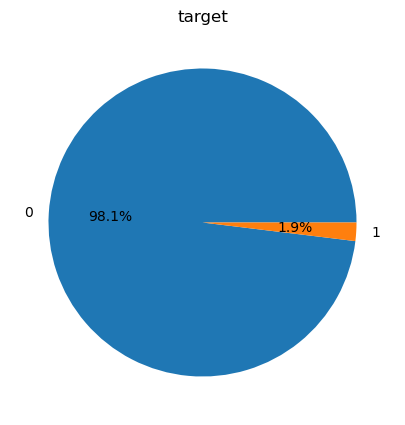

In [150]:
categ (data3, 'target', 2, 'target')

In [151]:
data3['client_id'].nunique()

49849

*Все клиенты в Таргете уникальные. Доля вернувшихся менее 2-х процентов. Очень большой дисбаланс.*

# Агрегация и добавление признаков в apparel_purchases.

In [154]:
apparel_purchases.columns

Index(['client_id', 'quantity', 'price', 'category_ids', 'date', 'message_id',
       'category'],
      dtype='object')

### quantity

In [156]:
df_quantity = apparel_purchases.groupby('client_id')['quantity'].sum(numeric_only=True)
df_quantity

client_id
1515915625468060902     7
1515915625468061003     7
1515915625468061099     1
1515915625468061100     2
1515915625468061170    19
                       ..
1515915626010261344     6
1515915626010266132     2
1515915626010439406     2
1515915626010443527     1
1515915626010443624     1
Name: quantity, Length: 49849, dtype: int64

*Добавили столбец с общим количеством купленного товара каждым клиентом.*

### price

In [159]:
df_price = apparel_purchases.groupby('client_id')['price'].sum(numeric_only=True)
df_price

client_id
1515915625468060902     6993.0
1515915625468061003    16235.0
1515915625468061099      299.0
1515915625468061100     2098.0
1515915625468061170    33601.0
                        ...   
1515915626010261344     8994.0
1515915626010266132     1818.0
1515915626010439406      198.0
1515915626010443527     1999.0
1515915626010443624      999.0
Name: price, Length: 49849, dtype: float64

In [160]:
df = pd.concat([df_quantity, df_price], axis=1)
df

,quantity,price
client_id,,
1515915625468060902,7,6993.0
1515915625468061003,7,16235.0
1515915625468061099,1,299.0
1515915625468061100,2,2098.0
1515915625468061170,19,33601.0
...,...,...
1515915626010261344,6,8994.0
1515915626010266132,2,1818.0
1515915626010439406,2,198.0


*Добавили столбец с общей суммой денег, потраченной каждым клиентом.*

### category_ids

Выбрала самую популярную категорию, если популярных категорий несколько, выбрала последнюю из них.

In [164]:
df_category_ids_mode = apparel_purchases.groupby('client_id')['category_ids'].apply(lambda x: x.mode().iloc[-1])


In [165]:
df_category_ids_mode

client_id
1515915625468060902      ['4', '28', '260', '420']
1515915625468061003      ['4', '28', '249', '615']
1515915625468061099      ['4', '28', '290', '424']
1515915625468061100    ['4', '27', '1828', '5717']
1515915625468061170      ['4', '28', '260', '420']
                                  ...             
1515915626010261344      ['2', '18', '212', '726']
1515915626010266132      ['4', '27', '278', '470']
1515915626010439406      ['4', '27', '233', '462']
1515915626010443527      ['2', '18', '274', '446']
1515915626010443624       ['4', '28', '62', '656']
Name: category_ids, Length: 49849, dtype: object

In [166]:
df = pd.concat([df, df_category_ids_mode], axis=1)
df

,quantity,price,category_ids
client_id,,,
1515915625468060902,7,6993.0,"['4', '28', '260', '420']"
1515915625468061003,7,16235.0,"['4', '28', '249', '615']"
1515915625468061099,1,299.0,"['4', '28', '290', '424']"
1515915625468061100,2,2098.0,"['4', '27', '1828', '5717']"
1515915625468061170,19,33601.0,"['4', '28', '260', '420']"
...,...,...,...
1515915626010261344,6,8994.0,"['2', '18', '212', '726']"
1515915626010266132,2,1818.0,"['4', '27', '278', '470']"
1515915626010439406,2,198.0,"['4', '27', '233', '462']"


*Создан столбец с самой частой категорией (с типом "строка") по каждому клиенту*.

### category

In [169]:
df_category_mode = apparel_purchases.groupby('client_id')['category'].apply(lambda x: x.mode().iloc[-1])
df_category_mode

client_id
1515915625468060902     458
1515915625468061003     615
1515915625468061099     424
1515915625468061100    5717
1515915625468061170     420
                       ... 
1515915626010261344     726
1515915626010266132     470
1515915626010439406     462
1515915626010443527     446
1515915626010443624     656
Name: category, Length: 49849, dtype: int64

In [170]:
df = pd.concat([df, df_category_mode], axis=1)
df

,quantity,price,category_ids,category
client_id,,,,
1515915625468060902,7,6993.0,"['4', '28', '260', '420']",458
1515915625468061003,7,16235.0,"['4', '28', '249', '615']",615
1515915625468061099,1,299.0,"['4', '28', '290', '424']",424
1515915625468061100,2,2098.0,"['4', '27', '1828', '5717']",5717
1515915625468061170,19,33601.0,"['4', '28', '260', '420']",420
...,...,...,...,...
1515915626010261344,6,8994.0,"['2', '18', '212', '726']",726
1515915626010266132,2,1818.0,"['4', '27', '278', '470']",470
1515915626010439406,2,198.0,"['4', '27', '233', '462']",462


*Создан столбец с самой частой категорией (с типом "число") по каждому клиенту*.

### date

Количество дней покупок.

In [174]:
df_date_count = apparel_purchases.groupby('client_id')['date'].apply(lambda x: x.nunique())
df = pd.concat([df, df_date_count], axis=1)
df

,quantity,price,category_ids,category,date
client_id,,,,,
1515915625468060902,7,6993.0,"['4', '28', '260', '420']",458,1
1515915625468061003,7,16235.0,"['4', '28', '249', '615']",615,1
1515915625468061099,1,299.0,"['4', '28', '290', '424']",424,1
1515915625468061100,2,2098.0,"['4', '27', '1828', '5717']",5717,1
1515915625468061170,19,33601.0,"['4', '28', '260', '420']",420,3
...,...,...,...,...,...
1515915626010261344,6,8994.0,"['2', '18', '212', '726']",726,1
1515915626010266132,2,1818.0,"['4', '27', '278', '470']",470,1
1515915626010439406,2,198.0,"['4', '27', '233', '462']",462,1


Количество дней от даты выгрузки до последнйе даты действия.

In [176]:
max_date = datetime.strptime("2024-02-16", "%Y-%m-%d")
df_date_end = apparel_purchases.groupby('client_id')['date'].apply(lambda x: max_date - x.iloc[-1])
df = pd.concat([df, df_date_end], axis=1)
df.columns.values[4] = 'day_count'
df


,quantity,price,category_ids,category,day_count,date
client_id,,,,,,
1515915625468060902,7,6993.0,"['4', '28', '260', '420']",458,1,630 days
1515915625468061003,7,16235.0,"['4', '28', '249', '615']",615,1,408 days
1515915625468061099,1,299.0,"['4', '28', '290', '424']",424,1,640 days
1515915625468061100,2,2098.0,"['4', '27', '1828', '5717']",5717,1,6 days
1515915625468061170,19,33601.0,"['4', '28', '260', '420']",420,3,244 days
...,...,...,...,...,...,...
1515915626010261344,6,8994.0,"['2', '18', '212', '726']",726,1,0 days
1515915626010266132,2,1818.0,"['4', '27', '278', '470']",470,1,2 days
1515915626010439406,2,198.0,"['4', '27', '233', '462']",462,1,0 days


In [177]:
df['date'] = df['date'].dt.days
df

,quantity,price,category_ids,category,day_count,date
client_id,,,,,,
1515915625468060902,7,6993.0,"['4', '28', '260', '420']",458,1,630
1515915625468061003,7,16235.0,"['4', '28', '249', '615']",615,1,408
1515915625468061099,1,299.0,"['4', '28', '290', '424']",424,1,640
1515915625468061100,2,2098.0,"['4', '27', '1828', '5717']",5717,1,6
1515915625468061170,19,33601.0,"['4', '28', '260', '420']",420,3,244
...,...,...,...,...,...,...
1515915626010261344,6,8994.0,"['2', '18', '212', '726']",726,1,0
1515915626010266132,2,1818.0,"['4', '27', '278', '470']",470,1,2
1515915626010439406,2,198.0,"['4', '27', '233', '462']",462,1,0


*Получили два столбца с количеством дней покупок и количеством дней от последней даты действия до даты выгрузки*

## average_bill (средний чек по каждому клиенту)

In [180]:
df['average_bill'] = df['price']/df['day_count']
df

,quantity,price,category_ids,category,day_count,date,average_bill
client_id,,,,,,,
1515915625468060902,7,6993.0,"['4', '28', '260', '420']",458,1,630,6993.000000
1515915625468061003,7,16235.0,"['4', '28', '249', '615']",615,1,408,16235.000000
1515915625468061099,1,299.0,"['4', '28', '290', '424']",424,1,640,299.000000
1515915625468061100,2,2098.0,"['4', '27', '1828', '5717']",5717,1,6,2098.000000
1515915625468061170,19,33601.0,"['4', '28', '260', '420']",420,3,244,11200.333333
...,...,...,...,...,...,...,...
1515915626010261344,6,8994.0,"['2', '18', '212', '726']",726,1,0,8994.000000
1515915626010266132,2,1818.0,"['4', '27', '278', '470']",470,1,2,1818.000000
1515915626010439406,2,198.0,"['4', '27', '233', '462']",462,1,0,198.000000


## average_number_of_items (cреднее количество товаров в день)

In [182]:
df['average_number_of_items'] = df['quantity']/df['day_count']
df

,quantity,price,category_ids,category,day_count,date,average_bill,average_number_of_items
client_id,,,,,,,,
1515915625468060902,7,6993.0,"['4', '28', '260', '420']",458,1,630,6993.000000,7.000000
1515915625468061003,7,16235.0,"['4', '28', '249', '615']",615,1,408,16235.000000,7.000000
1515915625468061099,1,299.0,"['4', '28', '290', '424']",424,1,640,299.000000,1.000000
1515915625468061100,2,2098.0,"['4', '27', '1828', '5717']",5717,1,6,2098.000000,2.000000
1515915625468061170,19,33601.0,"['4', '28', '260', '420']",420,3,244,11200.333333,6.333333
...,...,...,...,...,...,...,...,...
1515915626010261344,6,8994.0,"['2', '18', '212', '726']",726,1,0,8994.000000,6.000000
1515915626010266132,2,1818.0,"['4', '27', '278', '470']",470,1,2,1818.000000,2.000000
1515915626010439406,2,198.0,"['4', '27', '233', '462']",462,1,0,198.000000,2.000000


## message_id

In [184]:
df_message_count = apparel_purchases.groupby('client_id')['message_id'].apply(lambda x: x.nunique())
df = pd.concat([df, df_message_count], axis=1)
df

,quantity,price,category_ids,category,day_count,date,average_bill,average_number_of_items,message_id
client_id,,,,,,,,,
1515915625468060902,7,6993.0,"['4', '28', '260', '420']",458,1,630,6993.000000,7.000000,1
1515915625468061003,7,16235.0,"['4', '28', '249', '615']",615,1,408,16235.000000,7.000000,1
1515915625468061099,1,299.0,"['4', '28', '290', '424']",424,1,640,299.000000,1.000000,1
1515915625468061100,2,2098.0,"['4', '27', '1828', '5717']",5717,1,6,2098.000000,2.000000,1
1515915625468061170,19,33601.0,"['4', '28', '260', '420']",420,3,244,11200.333333,6.333333,3
...,...,...,...,...,...,...,...,...,...
1515915626010261344,6,8994.0,"['2', '18', '212', '726']",726,1,0,8994.000000,6.000000,1
1515915626010266132,2,1818.0,"['4', '27', '278', '470']",470,1,2,1818.000000,2.000000,1
1515915626010439406,2,198.0,"['4', '27', '233', '462']",462,1,0,198.000000,2.000000,1


Количество сообщений на каждого клиента по данным таблицы apparel_purchases.

Все признаки соединили в таблицу.

*Итак, из apparel_purchases получили таблицу df, состоящую из столбца с уникальными id клиентов, количеством купленных товаров, суммой, потраченной на товары, самой часто встречающейся для этого клиента категорией товара в стороков типе и категорйи с типом числа, количеством дней покупок, количеством дней с последней даты покупки до рассылки, количеством уникальных рассылок.*

## Соединим полученную таблицу и target.

In [189]:
df_reset = df.reset_index()
df_reset.head(3)

,client_id,quantity,price,category_ids,category,day_count,date,average_bill,average_number_of_items,message_id
0,1515915625468060902,7,6993.0,"['4', '28', '260', '420']",458,1,630,6993.0,7.0,1
1,1515915625468061003,7,16235.0,"['4', '28', '249', '615']",615,1,408,16235.0,7.0,1
2,1515915625468061099,1,299.0,"['4', '28', '290', '424']",424,1,640,299.0,1.0,1


In [190]:
purchases = data3.merge(df, on='client_id', how='left')
purchases.head(3)

,client_id,target,quantity,price,category_ids,category,day_count,date,average_bill,average_number_of_items,message_id
0,1515915625468060902,0,7,6993.0,"['4', '28', '260', '420']",458,1,630,6993.0,7.0,1
1,1515915625468061003,1,7,16235.0,"['4', '28', '249', '615']",615,1,408,16235.0,7.0,1
2,1515915625468061099,0,1,299.0,"['4', '28', '290', '424']",424,1,640,299.0,1.0,1


In [191]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   client_id                49849 non-null  int64  
 1   target                   49849 non-null  int64  
 2   quantity                 49849 non-null  int64  
 3   price                    49849 non-null  float64
 4   category_ids             49849 non-null  object 
 5   category                 49849 non-null  int64  
 6   day_count                49849 non-null  int64  
 7   date                     49849 non-null  int64  
 8   average_bill             49849 non-null  float64
 9   average_number_of_items  49849 non-null  float64
 10  message_id               49849 non-null  int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 4.2+ MB


*Получили таблицу purchases с агрегированными данными в качестве входящих признаков и целевой переменной: 49849 строк, 11 столбцов, включая id клиентов.*

## Добавление признаков в apparel_messages.

In [194]:
apparel_messages.columns

Index(['bulk_campaign_id', 'client_id', 'message_id', 'event', 'channel',
       'date', 'created_at', 'event_channel'],
      dtype='object')

### message_id

In [196]:
message_count = apparel_messages.groupby('client_id')['message_id'].apply(lambda x: x.nunique())
#data = pd.concat([data, data_message_last], axis=1)
message_count

client_id
1515915625468060902    127
1515915625468061003    154
1515915625468061099    215
1515915625468061100    268
1515915625468061170    243
                      ... 
1515915626010183608      2
1515915626010221592      2
1515915626010234726      1
1515915626010261344      1
1515915626010288690      1
Name: message_id, Length: 53329, dtype: int64

По тому же принципу создали столбец с количеством уникальных рассылок на каждого клиента.

### date

In [199]:
data_date_count = apparel_messages.groupby('client_id')['date'].apply(lambda x: x.nunique())
messages = pd.concat([message_count, data_date_count], axis=1)

messages

,message_id,date
client_id,,
1515915625468060902,127,136
1515915625468061003,154,155
1515915625468061099,215,191
1515915625468061100,268,228
1515915625468061170,243,212
...,...,...
1515915626010183608,2,1
1515915626010221592,2,1
1515915626010234726,1,1


Количество дат рассылок.

In [201]:
data_month_last = apparel_messages.groupby('client_id')['date'].apply(lambda x: x.iloc[-1].month)
data_month_last
messages = pd.concat([messages, data_month_last], axis=1)
messages.columns.values[1] = 'day_count'
messages.columns.values[2] = 'last_messages_month'
messages

,message_id,day_count,last_messages_month
client_id,,,
1515915625468060902,127,136,1
1515915625468061003,154,155,2
1515915625468061099,215,191,2
1515915625468061100,268,228,2
1515915625468061170,243,212,2
...,...,...,...
1515915626010183608,2,1,2
1515915626010221592,2,1,2
1515915626010234726,1,1,2


Месяц последней рассылки, т.к. возможно, сезонность влияет на таргет.

In [203]:
max_day  = datetime.strptime("2024-02-15", "%Y-%m-%d")
data_last_date = apparel_messages.groupby('client_id')['date'].apply(lambda x: max_day - x.iloc[-1])
messages = pd.concat([messages, data_last_date], axis=1)
messages

,message_id,day_count,last_messages_month,date
client_id,,,,
1515915625468060902,127,136,1,27 days
1515915625468061003,154,155,2,2 days
1515915625468061099,215,191,2,2 days
1515915625468061100,268,228,2,0 days
1515915625468061170,243,212,2,0 days
...,...,...,...,...
1515915626010183608,2,1,2,0 days
1515915626010221592,2,1,2,0 days
1515915626010234726,1,1,2,0 days


In [204]:
messages['count_day_last_messege'] = messages['date'].dt.days
messages = messages.drop('date',axis=1)
messages

,message_id,day_count,last_messages_month,count_day_last_messege
client_id,,,,
1515915625468060902,127,136,1,27
1515915625468061003,154,155,2,2
1515915625468061099,215,191,2,2
1515915625468061100,268,228,2,0
1515915625468061170,243,212,2,0
...,...,...,...,...
1515915626010183608,2,1,2,0
1515915626010221592,2,1,2,0
1515915626010234726,1,1,2,0


Количество дней, прошедших с последней даты действия до выгрузки.

*Таблицу рассылок сгруппировали по клиенту и взяли количество дней рассылки, месяц последней рассылки и количество дней от последней рассылки до дня выгрузки.*

### event_channel

In [208]:
event_channel_message = apparel_messages.groupby('client_id')['event_channel'].count()
messages = pd.concat([messages, event_channel_message], axis=1)
messages

,message_id,day_count,last_messages_month,count_day_last_messege,event_channel
client_id,,,,,
1515915625468060902,127,136,1,27,177
1515915625468061003,154,155,2,2,165
1515915625468061099,215,191,2,2,276
1515915625468061100,268,228,2,0,428
1515915625468061170,243,212,2,0,293
...,...,...,...,...,...
1515915626010183608,2,1,2,0,4
1515915626010221592,2,1,2,0,6
1515915626010234726,1,1,2,0,1


Количество действий каждого клиента.

*Итак, таблицу apparel_messages сгруппировали по id клиента и сформировали признаки: количество рекламных рассылок, количество дней рассылок, месяц последней рассылки, количество дней с последней рассылки до выгрузки, количество событий с рассылками. Получили таблицу с 53329 строками и 5 столбцами. Количество клиентов новой таблицы messages превышает количество клиентов таблицы purchases*.



## Соединим новую таблицу рассылок message с таблицей purchases.

Соединение проведем по таблице purchases.

In [212]:
table = purchases.merge(messages, on='client_id', how='left',  suffixes=('_purchases', '_messages'))
display(table.head())
table.info()

,client_id,target,quantity,price,category_ids,category,day_count_purchases,date,average_bill,average_number_of_items,message_id_purchases,message_id_messages,day_count_messages,last_messages_month,count_day_last_messege,event_channel
0,1515915625468060902,0,7,6993.0,"['4', '28', '260', '420']",458,1,630,6993.000000,7.000000,1,127.0,136.0,1.0,27.0,177.0
1,1515915625468061003,1,7,16235.0,"['4', '28', '249', '615']",615,1,408,16235.000000,7.000000,1,154.0,155.0,2.0,2.0,165.0
2,1515915625468061099,0,1,299.0,"['4', '28', '290', '424']",424,1,640,299.000000,1.000000,1,215.0,191.0,2.0,2.0,276.0
3,1515915625468061100,0,2,2098.0,"['4', '27', '1828', '5717']",5717,1,6,2098.000000,2.000000,1,268.0,228.0,2.0,0.0,428.0
4,1515915625468061170,0,19,33601.0,"['4', '28', '260', '420']",420,3,244,11200.333333,6.333333,3,243.0,212.0,2.0,0.0,293.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   client_id                49849 non-null  int64  
 1   target                   49849 non-null  int64  
 2   quantity                 49849 non-null  int64  
 3   price                    49849 non-null  float64
 4   category_ids             49849 non-null  object 
 5   category                 49849 non-null  int64  
 6   day_count_purchases      49849 non-null  int64  
 7   date                     49849 non-null  int64  
 8   average_bill             49849 non-null  float64
 9   average_number_of_items  49849 non-null  float64
 10  message_id_purchases     49849 non-null  int64  
 11  message_id_messages      41982 non-null  float64
 12  day_count_messages       41982 non-null  float64
 13  last_messages_month      41982 non-null  float64
 14  count_day_last_messege

In [213]:
print (f"Доля пропусков - {round(table['message_id_messages'].isna().sum()*100/table.shape[0],2)} %")

Доля пропусков - 15.78 %


Нет 15% важных данных. Предлагаю заполнить пропуски медианами.

**Вывод:** Получили датафрэйм с 49849 строками, 16 столбцами. Среди столбцов: целевой признак бинарной классификации и 14 входных признаков:

1. quantity  - количество товара на каждого клиента
2. price - общая сумма купленного товара
3. category_ids - категория товара (строка)
4. category - категория товара (число)
5. day_count_purchases - общее количество дней покупок
6. date - количество дней с последнего дня покупки до выгрузки базы
7. average_bill - средний чек
8. average_number_of_items - среднее количество товара
9. message_id_purchases - количество сообщений по базе покупок
10. message_id_messages - количество сообщений по базе сообщений
11. day_count_messages - количество дней, когда присылали сообщения
12. last_messages_month - месяц последнего сообщения
13. count_day_last_messege - количество дней с последнего сообщения до дня выгрузки
14. event_channel - количество событий



# Исследование новых признаков

In [217]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   client_id                49849 non-null  int64  
 1   target                   49849 non-null  int64  
 2   quantity                 49849 non-null  int64  
 3   price                    49849 non-null  float64
 4   category_ids             49849 non-null  object 
 5   category                 49849 non-null  int64  
 6   day_count_purchases      49849 non-null  int64  
 7   date                     49849 non-null  int64  
 8   average_bill             49849 non-null  float64
 9   average_number_of_items  49849 non-null  float64
 10  message_id_purchases     49849 non-null  int64  
 11  message_id_messages      41982 non-null  float64
 12  day_count_messages       41982 non-null  float64
 13  last_messages_month      41982 non-null  float64
 14  count_day_last_messege

In [218]:
table.columns

Index(['client_id', 'target', 'quantity', 'price', 'category_ids', 'category',
       'day_count_purchases', 'date', 'average_bill',
       'average_number_of_items', 'message_id_purchases',
       'message_id_messages', 'day_count_messages', 'last_messages_month',
       'count_day_last_messege', 'event_channel'],
      dtype='object')

## quantity

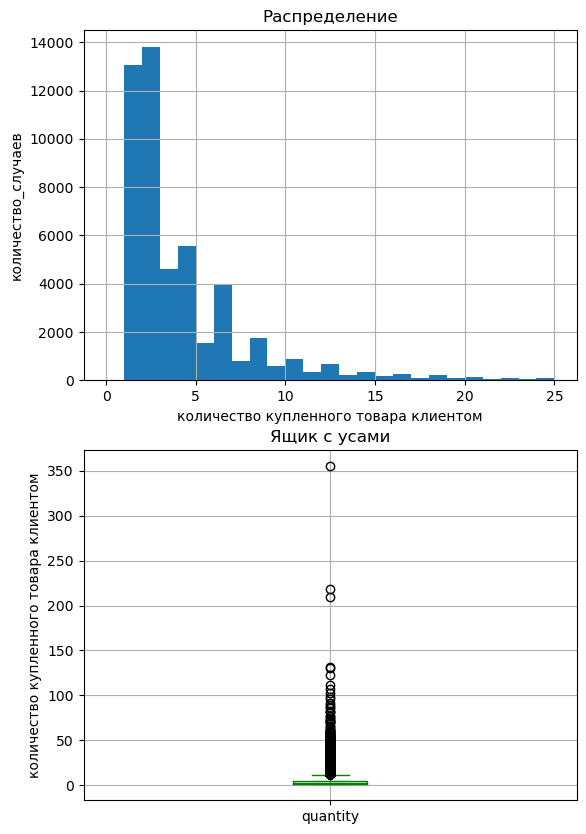

Статистика
count    49849.000000
mean         4.082710
std          5.562927
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        355.000000
Name: quantity, dtype: float64


In [220]:
numbers(table, 'quantity', 'количество купленного товара клиентом','количество_случаев')

В основном клиенты покупали 1-2 товара, но есть выбросы от 200 товаров.

## price

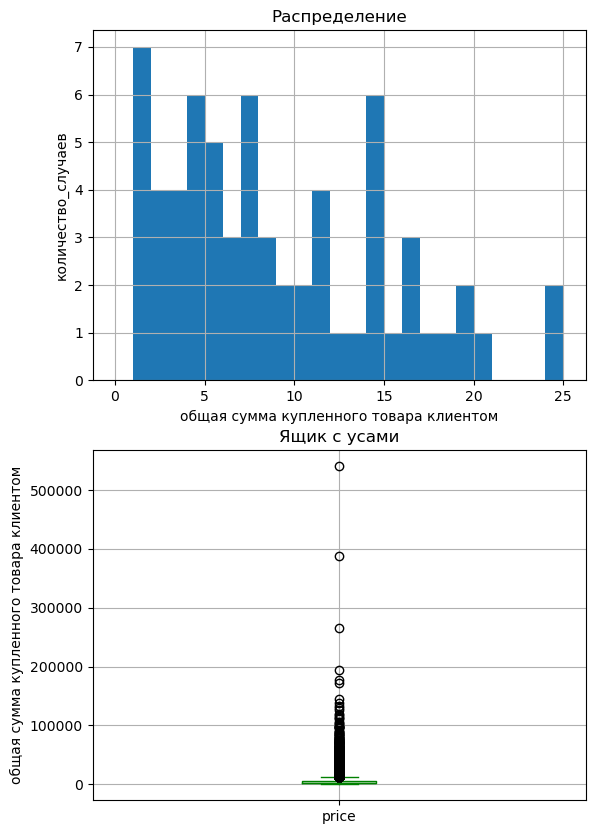

Статистика
count     49849.000000
mean       4840.520632
std        7312.865458
min           1.000000
25%        1499.000000
50%        2929.000000
75%        5677.000000
max      540408.000000
Name: price, dtype: float64


In [223]:
numbers(table, 'price', 'общая сумма купленного товара клиентом','количество_случаев')

В среднем покупали на 3 тыс. Но есть выбросы.

## category

In [226]:
table['category'].value_counts()

category
431     2695
432     2147
420     1681
441     1392
657     1372
        ... 
6305       1
914        1
1222       1
1429       1
1145       1
Name: count, Length: 765, dtype: int64

762 разных категории. Многие категории представлены одной строкой.

## category_id

In [229]:
table['category_ids'].value_counts()

category_ids
['4', '28', '57', '431']            3065
['4', '28', '244', '432']           2028
['4', '28', '260', '420']           1865
[]                                  1520
['2', '18', '258', '441']           1368
                                    ... 
['5562', '5632', '5638', '970']        1
['4', '28', '44', '1593']              1
['4', '5837', '5838', '5835']          1
['5562', '5536', '5581', '1420']       1
['5562', '5597', '5629', '5781']       1
Name: count, Length: 810, dtype: int64

810 категорий, много редких.

## target

target
0    48888
1      961
Name: count, dtype: int64


<Figure size 2200x1800 with 0 Axes>

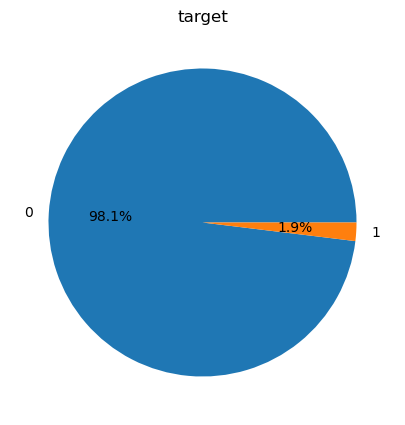

In [232]:
categ (table, 'target', 2, 'target')

Слишком большой дисбаланс.

## day_count_purchases ()

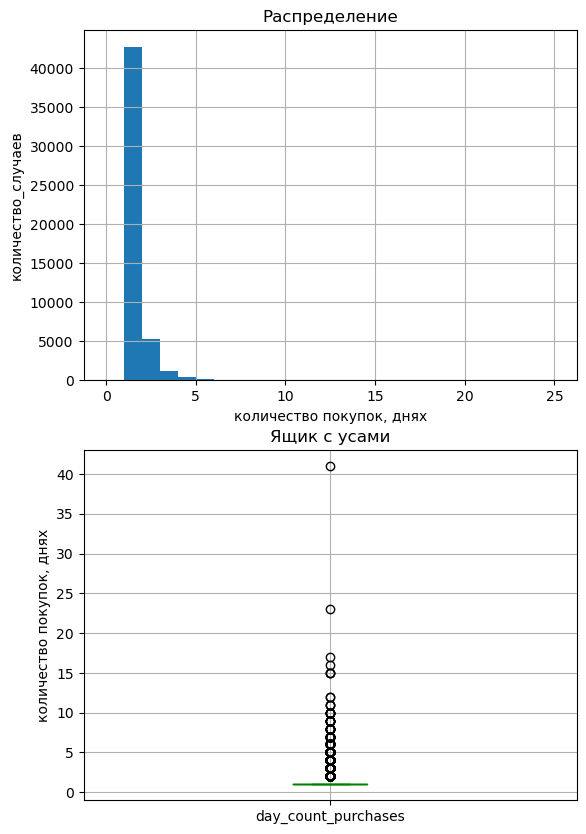

Статистика
count    49849.000000
mean         1.207808
std          0.665728
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         41.000000
Name: day_count_purchases, dtype: float64


In [235]:
numbers(table, 'day_count_purchases', 'количество покупок, днях','количество_случаев')

В основном от покупки делали только 1 день, но есть случаи 15 и более дней.

## date

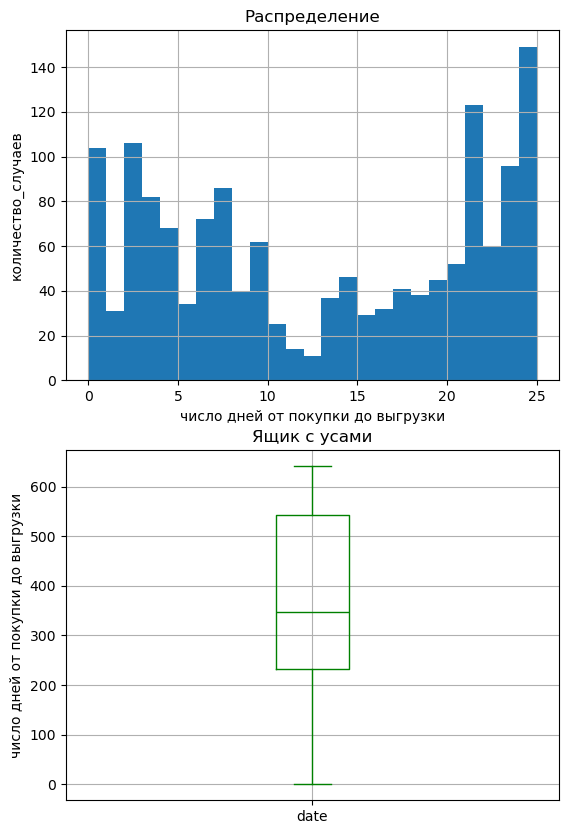

Статистика
count    49849.000000
mean       361.931593
std        185.301691
min          0.000000
25%        233.000000
50%        348.000000
75%        542.000000
max        641.000000
Name: date, dtype: float64


In [238]:
numbers(table, 'date', 'число дней от покупки до выгрузки','количество_случаев')

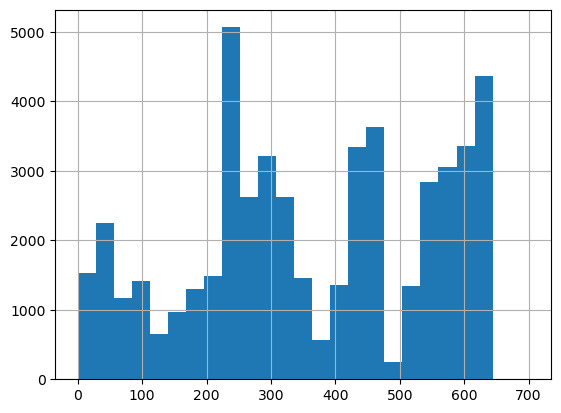

In [239]:
table['date'].hist(bins=25, range=(0,700));

Весь период, примерно 2 года, совершали покупки, в среднем 348 дней до выгрузки. Выбросов нет.

## average_bill

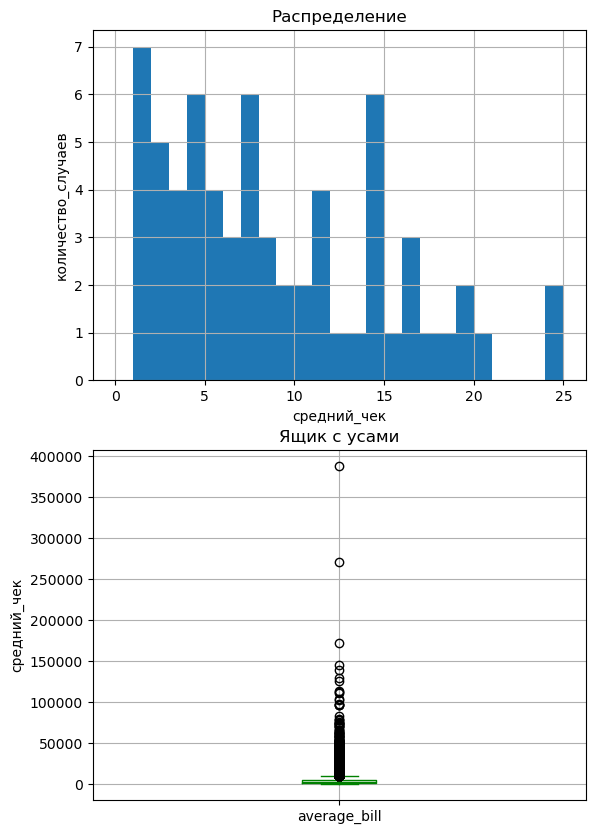

Статистика
count     49849.000000
mean       4023.049860
std        5523.700646
min           1.000000
25%        1498.000000
50%        2597.000000
75%        4894.000000
max      387583.000000
Name: average_bill, dtype: float64


In [242]:
numbers(table, 'average_bill', 'средний_чек','количество_случаев')

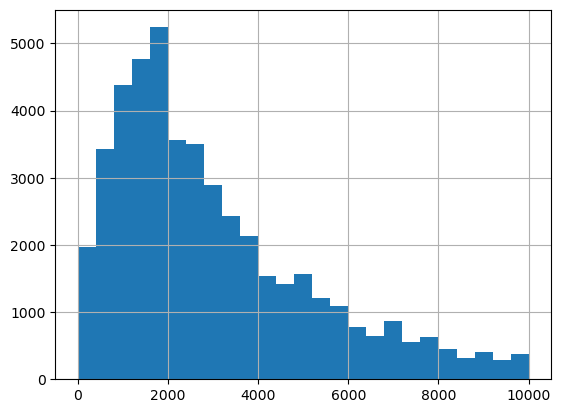

In [243]:
table['average_bill'].hist(bins=25, range=(0,10000));

В основном средний человек каждого клиента 1500-1800. Есть выбросы.

In [245]:
table.shape[0]

49849

## average_number_of_items (среднее количество товара в день)

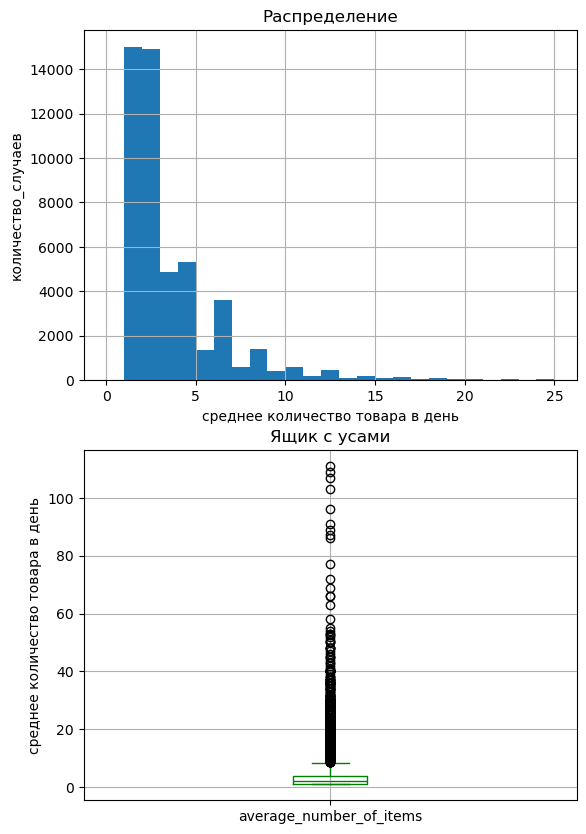

Статистика
count    49849.000000
mean         3.332598
std          3.779887
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        111.000000
Name: average_number_of_items, dtype: float64


In [247]:
numbers(table, 'average_number_of_items', 'среднее количество товара в день','количество_случаев')

В основном покупали товары 1,2 в день, но многие покупали 60 и более товаров.

## message_id_purchases

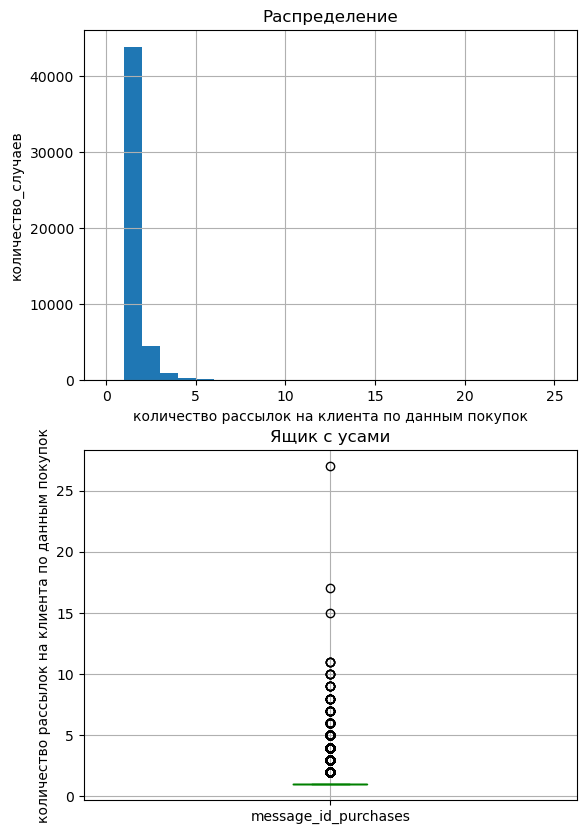

Статистика
count    49849.000000
mean         1.170174
std          0.576680
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         27.000000
Name: message_id_purchases, dtype: float64


In [250]:
numbers(table, 'message_id_purchases', 'количество рассылок на клиента по данным покупок','количество_случаев')

В основном это одна рассылка, но были и больше. Выбросы - более 14 рассылок.

## message_id_messages

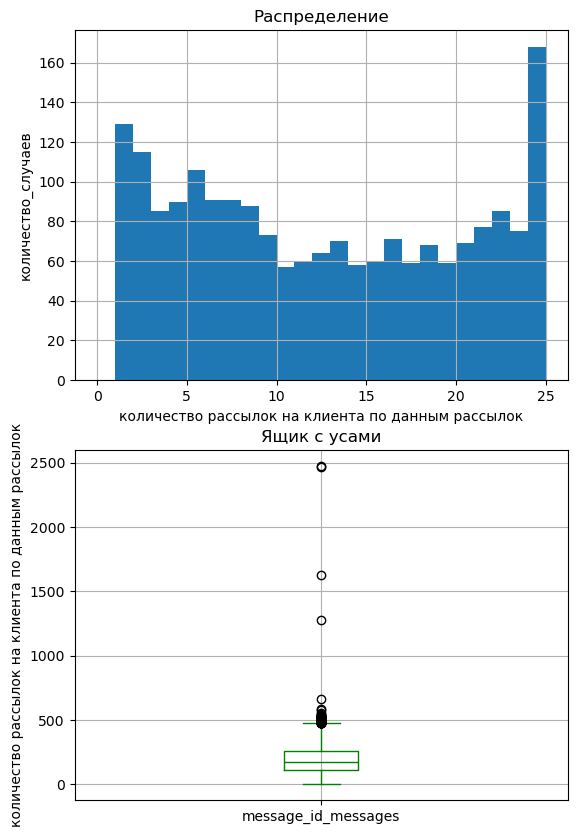

Статистика
count    41982.000000
mean       188.226478
std        104.672625
min          1.000000
25%        115.000000
50%        175.000000
75%        260.000000
max       2473.000000
Name: message_id_messages, dtype: float64


In [253]:
numbers(table, 'message_id_messages', 'количество рассылок на клиента по данным рассылок','количество_случаев')

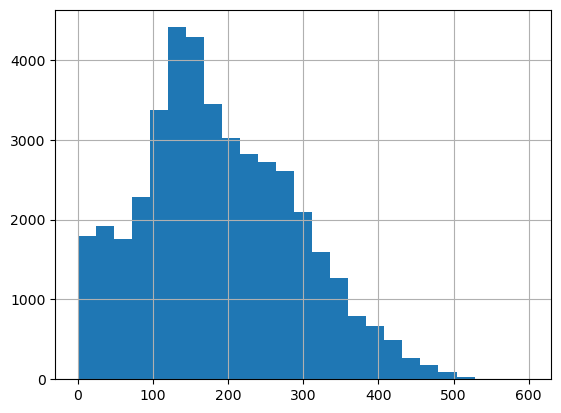

In [254]:
table['message_id_messages'].hist(bins=25, range=(0,600));

В основном рассылок разослано по 100-200 на клиента. Но есть выбросы, более 1000.


Заполним пропуски медианным значением.

In [257]:
median_value = table['message_id_messages'].median()
table['message_id_messages'] = table['message_id_messages'].fillna(median_value)


## day_count_messages

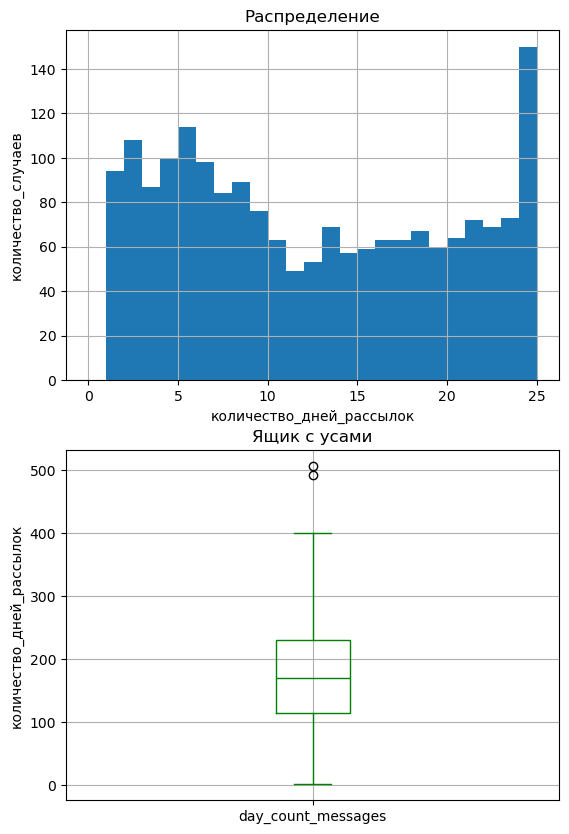

Статистика
count    41982.000000
mean       168.869492
std         79.934047
min          1.000000
25%        114.000000
50%        170.000000
75%        230.000000
max        506.000000
Name: day_count_messages, dtype: float64


In [259]:
numbers(table, 'day_count_messages', 'количество_дней_рассылок','количество_случаев')

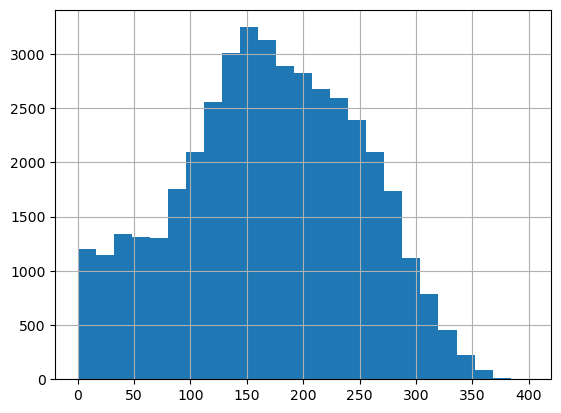

In [260]:
table['day_count_messages'].hist(bins=25, range=(0,400));

Количество дней рассылок на человека могло длиться от 0 до 400 дней.

Заполним пропуски медианным значением.

In [262]:
median_value = table['day_count_messages'].median()
table['day_count_messages'] = table['day_count_messages'].fillna(median_value)
table.shape[0]

49849

## last_messages_month

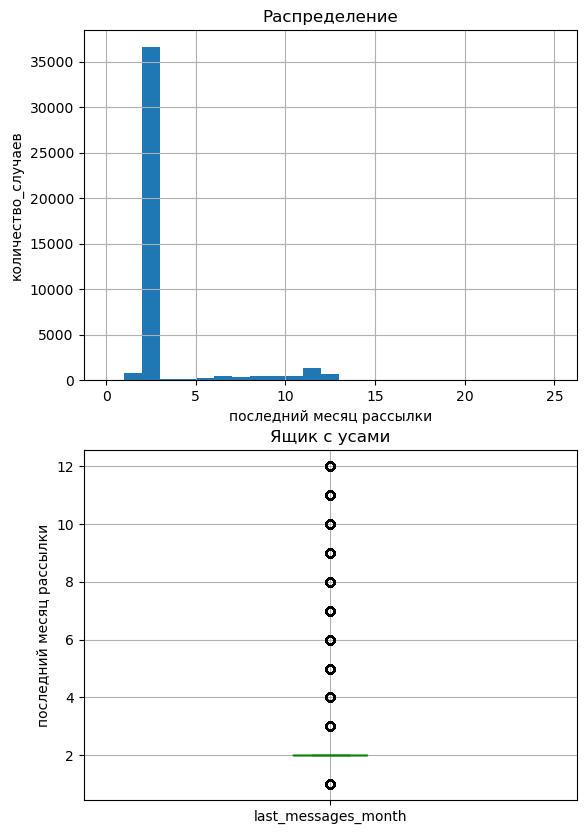

Статистика
count    41982.000000
mean         2.748654
std          2.358063
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         12.000000
Name: last_messages_month, dtype: float64


In [264]:
numbers(table, 'last_messages_month', 'последний месяц рассылки','количество_случаев')

В основном в феврале. Закономерно, ведь база выгружена в феврале. Неинформативный признак.

## count_day_last_messege

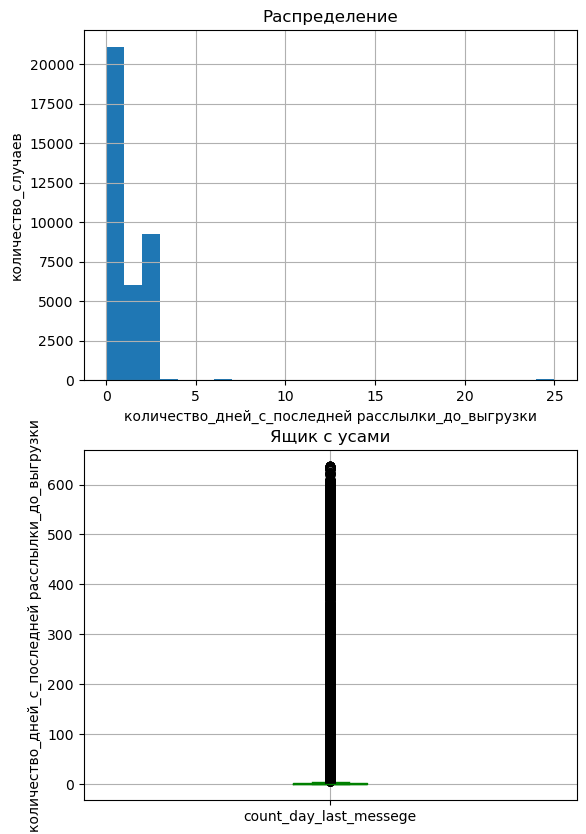

Статистика
count    41982.000000
mean        38.542351
std        117.678575
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        637.000000
Name: count_day_last_messege, dtype: float64


In [267]:
numbers(table, 'count_day_last_messege', 'количество_дней_с_последней расслылки_до_выгрузки','количество_случаев')

В основном прошел один день с последней рассылки. Но много строк, где больше.

Заполним пропуски медианным значением.

In [269]:
median_value = table['count_day_last_messege'].median()
table['count_day_last_messege'] = table['count_day_last_messege'].fillna(median_value)
table.shape[0]

49849

## event_channel

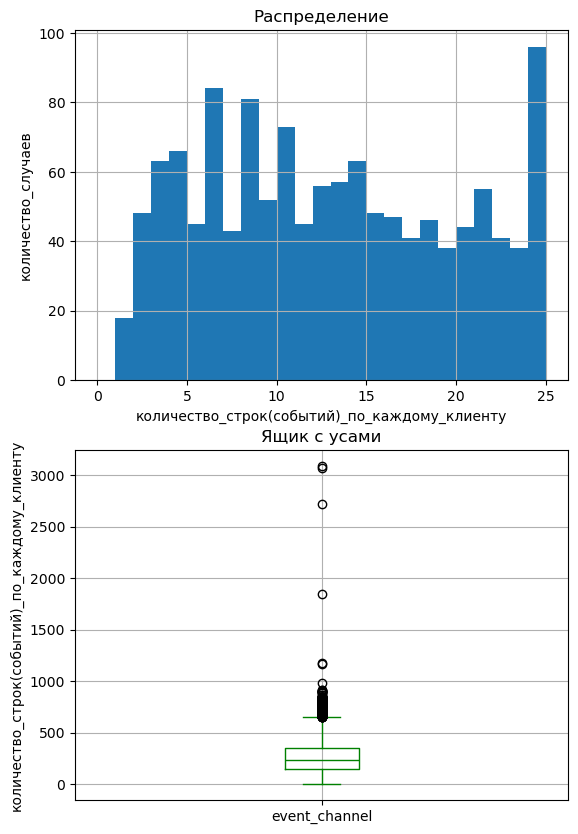

Статистика
count    41982.000000
mean       259.949431
std        158.924410
min          1.000000
25%        147.000000
50%        233.000000
75%        351.000000
max       3088.000000
Name: event_channel, dtype: float64


In [271]:
numbers(table, 'event_channel', 'количество_строк(событий)_по_каждому_клиенту','количество_случаев')

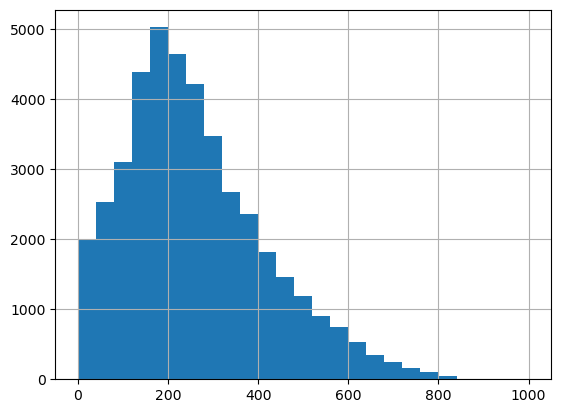

In [272]:
table['event_channel'].hist(bins=25, range=(0,1000));

В основном это от 80 до 150 событий, но есть выбросы: более 1000 событий.

Заполним пропуски медианным значением.

In [275]:
median_value = table['event_channel'].median()
table['event_channel'] = table['event_channel'].fillna(median_value)
table.shape[0]

49849

# Мультиколлинеарность

In [277]:
table.columns


Index(['client_id', 'target', 'quantity', 'price', 'category_ids', 'category',
       'day_count_purchases', 'date', 'average_bill',
       'average_number_of_items', 'message_id_purchases',
       'message_id_messages', 'day_count_messages', 'last_messages_month',
       'count_day_last_messege', 'event_channel'],
      dtype='object')

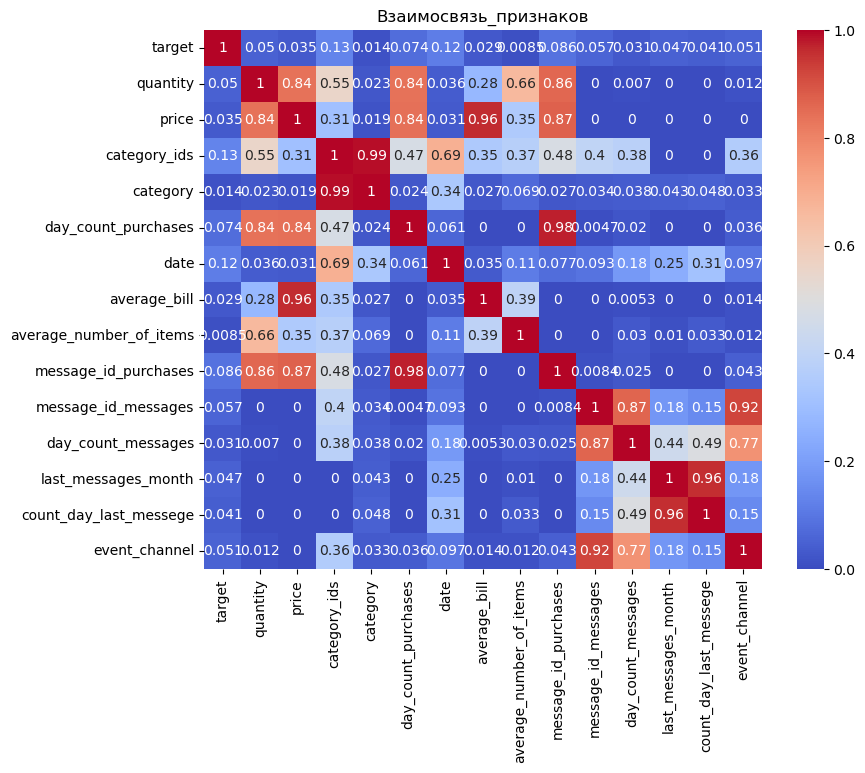

In [278]:
interval_cols = ['target', 'quantity', 'price', 'category',
       'day_count_purchases', 'date', 'average_bill', 'message_id_purchases',
       'message_id_messages', 'day_count_messages', 'last_messages_month',
       'count_day_last_messege', 'event_channel', 'average_number_of_items']

corr_matrix = table.drop('client_id', axis=1)[table.drop('client_id', axis=1).columns].phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(9, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Взаимосвязь_признаков')
plt.show()

Утечки нет. Но есть коллинеарные признаки:

- category_ids и category, уберем category_ids.
- last_messages_month и count_day_last_messege. Уберем last_messages_month. 

После устранения мультиколлинеарности признаков, осталось 12 входных признаков.

# Модель для классификации пользователей.

## Подготовка признаков.

In [282]:
table.columns

Index(['client_id', 'target', 'quantity', 'price', 'category_ids', 'category',
       'day_count_purchases', 'date', 'average_bill',
       'average_number_of_items', 'message_id_purchases',
       'message_id_messages', 'day_count_messages', 'last_messages_month',
       'count_day_last_messege', 'event_channel'],
      dtype='object')

In [283]:
num_columns = ['quantity', 'price', 'category',
       'day_count_purchases', 'date', 'average_bill', 'message_id_purchases',
       'average_number_of_items', 'message_id_messages', 'day_count_messages',
       'count_day_last_messege', 'event_channel'] 

In [284]:
del_columns = ['client_id', 'target', 'category_ids', 'last_messages_month']

In [285]:
X_train, X_test, y_train, y_test = train_test_split(
    table.drop(del_columns, axis=1), table.target, test_size=0.25, random_state=RANDOM_STATE, stratify = table.target)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(37386, 12)
(37386,)
(12463, 12)
(12463,)


In [286]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

data_preprocessor = ColumnTransformer( 
    [('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
).set_output(transform="pandas")

## Выбор и обучение моделей.

In [288]:
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='saga',
            class_weight='balanced',
            penalty='l2',
            max_iter = 1500
            
        )],
        'models__C': [0.1, 1, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]


rn_vyb = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    n_iter=20,
    random_state=RANDOM_STATE
)


rn_vyb.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', rn_vyb.best_estimator_)

print('Метрика ROC-AUC для лучшей модели:\n', rn_vyb.best_score_)

/home/olesya/anaconda3/envs/sklearn152/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/olesya/anaconda3/envs/sklearn152/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/olesya/anaconda3/envs/sklearn152/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/olesya/anaconda3/envs/sklearn152/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/olesya/anaconda3/envs/sklearn152/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['quantity', 'price',
                                                   'category',
                                                   'day_count_purchases',
                                                   'date', 'average_bill',
                                                   'message_id_purchases',
                                                   'average_number_of_items',
                                                   'message_id_messages',
                                                   'day_count_messages',
                                                   'count_day_last_messege',
                                                   'event_channel'])])),
                ('models',
                 LogisticRegression(C=1

/home/olesya/anaconda3/envs/sklearn152/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Выберем самые важные признаки

## Первый метод

In [290]:
model =  LogisticRegression(C=1, class_weight='balanced', max_iter=1500,
                                    random_state=1234, solver='saga')
model.fit(X_train, y_train)

/home/olesya/anaconda3/envs/sklearn152/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=1, class_weight='balanced', max_iter=1500,
                   random_state=1234, solver='saga')

In [291]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print(feature_importance)

                    Feature  Coefficient
11            event_channel     0.003401
4                      date    -0.002421
10   count_day_last_messege    -0.001426
8       message_id_messages    -0.001121
9        day_count_messages    -0.000551
0                  quantity     0.000262
6   average_number_of_items     0.000090
5              average_bill    -0.000090
1                     price     0.000084
7      message_id_purchases     0.000064
3       day_count_purchases     0.000063
2                  category     0.000018


## Второй метод

In [293]:
selector = SelectFromModel(model, threshold='median')
selector.fit(X_train, y_train)

selected_features = X_train.columns[selector.get_support()]
print("Отобранные признаки:", selected_features)

Отобранные признаки: Index(['quantity', 'date', 'message_id_messages', 'day_count_messages',
       'count_day_last_messege', 'event_channel'],
      dtype='object')


/home/olesya/anaconda3/envs/sklearn152/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Оба метода выбрали похожие признаки. Попробуем увеличить метрику, убрав наименее важные категории.

In [295]:
del_unimportant = ['day_count_purchases','price', 'last_messages_month', 'client_id', 'target', 'category_ids', 'category', 'average_bill']

In [296]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   client_id                49849 non-null  int64  
 1   target                   49849 non-null  int64  
 2   quantity                 49849 non-null  int64  
 3   price                    49849 non-null  float64
 4   category_ids             49849 non-null  object 
 5   category                 49849 non-null  int64  
 6   day_count_purchases      49849 non-null  int64  
 7   date                     49849 non-null  int64  
 8   average_bill             49849 non-null  float64
 9   average_number_of_items  49849 non-null  float64
 10  message_id_purchases     49849 non-null  int64  
 11  message_id_messages      49849 non-null  float64
 12  day_count_messages       49849 non-null  float64
 13  last_messages_month      41982 non-null  float64
 14  count_day_last_messege

In [297]:
X_train_imp, X_test_imp, y_train, y_test = train_test_split(
    table.drop(del_unimportant, axis=1), table.target, test_size=0.25, random_state=RANDOM_STATE, stratify = table.target)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(37386, 12)
(37386,)
(12463, 12)
(12463,)


In [298]:
num_columns = ['event_channel', 'count_day_last_messege', 'message_id_messages', 'date', 'quantity', 'day_count_messages', 'average_number_of_items'
               , 'message_id_purchases'] 

In [299]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

data_preprocessor = ColumnTransformer( 
     [('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
).set_output(transform="pandas")

pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])


In [300]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='saga',
            class_weight='balanced',
            penalty='l2',
            max_iter = 1500
            
        )],
        'models__C': [0.1,1,2],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]


rn = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    n_iter=20,
    random_state=RANDOM_STATE
)


rn.fit(X_train_imp, y_train)

print('Лучшая модель и её параметры:\n\n', rn.best_estimator_)

print('Метрика ROC-AUC для лучшей модели:\n', rn.best_score_)

/home/olesya/anaconda3/envs/sklearn152/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/olesya/anaconda3/envs/sklearn152/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/olesya/anaconda3/envs/sklearn152/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/olesya/anaconda3/envs/sklearn152/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/olesya/anaconda3/envs/sklearn152/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['event_channel',
                                                   'count_day_last_messege',
                                                   'message_id_messages',
                                                   'date', 'quantity',
                                                   'day_count_messages',
                                                   'average_number_of_items',
                                                   'message_id_purchases'])])),
                ('models',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=1500,
                                    random_state=42, solver='saga'))])
Метрика ROC-AUC для лучшей модели:
 0.7246076258429719


Метрика лучше.

# Oversampling

Поробуем увеличить метрику уменьшением дисбаланса таргета.

In [303]:
smote = SMOTE()
X_res, y_res = smote.fit_resample(X_train, y_train)

In [304]:
X_res

,quantity,price,category,day_count_purchases,date,average_bill,average_number_of_items,message_id_purchases,message_id_messages,day_count_messages,count_day_last_messege,event_channel
0,1,1999.000000,1561,1,462,1999.000000,1.000000,1,102.000000,113.000000,2.000000,139.000000
1,4,11496.000000,673,2,586,5748.000000,2.000000,1,130.000000,129.000000,2.000000,132.000000
2,2,3798.000000,415,1,637,3798.000000,2.000000,1,27.000000,27.000000,286.000000,49.000000
3,9,9893.000000,656,2,84,4946.500000,4.500000,2,128.000000,126.000000,0.000000,145.000000
4,12,4585.000000,1342,1,48,4585.000000,12.000000,1,171.000000,146.000000,1.000000,178.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
73325,3,4211.957029,1600,1,494,4211.957029,3.505689,1,308.930455,285.953212,0.000000,523.332462
73326,4,5120.266108,433,2,151,2560.133054,2.073554,2,188.533860,177.502466,0.000000,247.710718
73327,9,7717.274379,1084,2,249,3858.637189,4.904850,2,195.096996,186.429099,0.452425,273.764892
73328,10,2788.956765,521,1,253,2788.956765,10.870296,1,141.276226,130.796908,0.000000,173.016819


In [305]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

data_preprocessor = ColumnTransformer( 
     [('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
).set_output(transform="pandas")

In [306]:
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='saga',
#            class_weight='balanced',
            penalty='l2',
            max_iter = 1500
            
        )],
        'models__C': [0.1, 1, 2,3,4,5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]


rn_over = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    n_iter=20,
    random_state=RANDOM_STATE
)


rn_over.fit(X_res, y_res)

print('Лучшая модель и её параметры:\n\n', rn_over.best_estimator_)

print('Метрика ROC-AUC для лучшей модели:\n', rn_over.best_score_)

/home/olesya/anaconda3/envs/sklearn152/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/olesya/anaconda3/envs/sklearn152/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/olesya/anaconda3/envs/sklearn152/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/olesya/anaconda3/envs/sklearn152/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/olesya/anaconda3/envs/sklearn152/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  ['event_channel',
                                                   'count_day_last_messege',
                                                   'message_id_messages',
                                                   'date', 'quantity',
                                                   'day_count_messages',
                                                   'average_number_of_items',
                                                   'message_id_purchases'])])),
                ('models', KNeighborsClassifier(n_neighbors=3))])
Метрика ROC-AUC для лучшей модели:
 0.9608351803452478


/home/olesya/anaconda3/envs/sklearn152/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Метрика стала очень хорошей.

# LightGBM

In [309]:
X_train

,quantity,price,category,day_count_purchases,date,average_bill,average_number_of_items,message_id_purchases,message_id_messages,day_count_messages,count_day_last_messege,event_channel
1094,1,1999.0,1561,1,462,1999.0,1.0,1,102.0,113.0,2.0,139.0
12518,4,11496.0,673,2,586,5748.0,2.0,1,130.0,129.0,2.0,132.0
23044,2,3798.0,415,1,637,3798.0,2.0,1,27.0,27.0,286.0,49.0
20369,9,9893.0,656,2,84,4946.5,4.5,2,128.0,126.0,0.0,145.0
41882,12,4585.0,1342,1,48,4585.0,12.0,1,171.0,146.0,1.0,178.0
...,...,...,...,...,...,...,...,...,...,...,...,...
21004,2,3398.0,425,1,623,3398.0,2.0,1,63.0,65.0,387.0,73.0
14811,2,1818.0,415,1,241,1818.0,2.0,1,118.0,122.0,2.0,143.0
25488,2,2598.0,1728,2,591,1299.0,1.0,2,266.0,241.0,0.0,275.0
13639,2,3798.0,420,2,541,1899.0,1.0,1,159.0,160.0,2.0,173.0


In [310]:
train_data = lgb.Dataset(X_train, label=y_train)

In [311]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate":0.05,
    #"num_leaves":40,
     "max_depth": 6,
    "min_data_in_leaf": 20,
    "feature_fraction": 0.8,
    "lambda_l1": 0.1,
    "lambda_l2": 0.2
#    "categorical_feature": categorical_features
}
model_lgb = lgb.train(params, train_data)
y_pred = model_lgb.predict(X_train)
#y_pred_proba = model_lgb.predict_proba(X_train)[:, 1]
print('Метрика ROC-AUC для модели LigthGBM:\n', roc_auc_score(y_train, y_pred))

#print('Время обучения модели LightGBM',time.time() - start)

[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=6) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=64) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=6) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=64) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2240
[LightGBM] [Info] Number of data points in the train set: 37386, number of used features: 12
[LightGBM] [Info] Start training from score 0.019285
[LightGBM] [Warning] No further splits with positive gai

Метрика похуже, на втором месте.

# Тестирование

In [314]:
y_test_pred = rn_over.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.546073658948976


После оверсэмплинга модель преобучилась. Метрика на тестовой выборке очень плохая.

Значит, возьмем следующую по размеру метрики модель LigthGBM и вычислим метрику на тестовых данных на этой модели.

In [316]:
y_test_pred = model_lgb.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.7263771850882217


Метрика модели LigthGBM на тестовых данных лучше, чем метрика на выборочных признаках на тренирововных данных. 

In [318]:
print('Время выполнения кода в мин. -',(time.time() - start)/60)

Время выполнения кода в мин. - 11.208738203843435


**ВЫВОД:** Лучшую метрику показала модель LigthGBM. Её метрика ROC-AUC на тестовой выборке составила 0,73. 

Таким образом, найдена модель которая предскажет интернет-магазину совершение повторной покупки пользователями в течение 90 дней.